## Data Preparation

Loads common imports, and defines some generic SPSS functions.

In [185]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import savReaderWriter
import seaborn as sns

from osgeo import gdal

Custom imports.

In [186]:
import common as c


General instructions.

In [187]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Parameters
plt.rcParams["figure.figsize"] = (12,9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Imports the [fastai](http://fast.ai) library.

In [188]:
import sys
sys.path.append('/home/ubuntu/repos/fastai')

In [189]:
import fastai
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='/home/ubuntu/jupyter/data/path/'

Generate list of variables

### Load Data

In [190]:
ds = c.DataSet("data/acf.sav")

In [191]:
import tabulate
from IPython.display import HTML, display
s = tabulate.tabulate(([x.decode('utf-8'), y.decode('utf-8')] for x, y in ds.metadata.varLabels.items()), tablefmt='html')
with open("acf-metadata.html", "w") as text_file:
     text_file.write(s)
# display(HTML(s))

#### Scores

Cultural field participation scores

In [192]:
ds.freq_table('Q17')

,"Are you a member of a sports club? This includes participation sports clubs, as well as being a member of a supporters club.",Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,Yes,390,32.4,394.356113,32.8
2.0,No,812,67.6,807.843044,67.2


In [193]:
ds.data = ds.data.assign(score_music_hours = (ds.data['Q24'] - 1.) / 3.,
                         score_music_frequency = (5. - ds.data[['Q26A', 'Q26B', 'Q26C', 'Q26D', 'Q26E', 'Q26F']]).sum(axis=1) / 24.)
ds.data = ds.data.assign(score_heritage_internet = (4. - (ds.data['Q37'] - 1.)) / 4.,
                         score_heritage_visits = ( ds.data[['Q31C1', 'Q31C2', 'Q31C3', 'Q31C4', 'Q31C5', 'Q31C6', 'Q31C7', 'Q31C8', 'Q31C9', 'Q31C10', 'Q31C11']].sum(axis=1))  / 11. ,
                         score_heritage_subscriber = (ds.data[['Q32C1', 'Q32C2', 'Q32C3', 'Q32C4', 'Q32C5', 'Q32C6', 'Q32C7', 'Q32C8']].sum(axis=1)) / 8.)
ds.data = ds.data.assign(score_gallery = (4. - (ds.data['Q38'] - 1.)) / 4.,
                          score_locations = ds.data[['Q39C1', 'Q39C2', 'Q39C3', 'Q39C4', 'Q39C5', 'Q39C6', 'Q39C7', 'Q39C8']].sum(axis=1) / 8.,
                          score_internet = ds.data[['Q40C1', 'Q40C2', 'Q40C3', 'Q40C4']].sum(axis=1) / 4.)
ds.data = ds.data.assign(score_lit_aus_books = (ds.data[ds.data['Q49']<8.0]['Q49'] - 1.) / 4., 
                         score_lit_books = (ds.data['Q50'] - 1.) / 4.,
                         score_lit_ebooks = (ds.data['Q51'] - 1.) / 6.,
                         score_lit_attendance = (5. - ds.data[['Q53A', 'Q53B', 'Q53C', 'Q53D', 'Q53E', 'Q53F', 'Q53G']]).sum(axis=1) / 28.)

ds.data = ds.data.assign(score_television_hours = (ds.data['Q5'] - 1.) / 3.)
ds.data = ds.data.assign(score_sports_play = (5. - (ds.data['Q16'])) / 4.,
                         score_sports_clubs = ( ds.data[['Q18C1', 'Q18C2', 'Q18C3', 'Q18C4', 'Q18C5', 'Q18C6', 'Q18C7', 'Q18C8', 'Q18C9', 'Q18C10']].sum(axis=1))  / 10. ,
                         score_sports_watched_live = ( ds.data[['Q19C1', 'Q19C2', 'Q19C3', 'Q19C4', 'Q19C5', 'Q19C6', 'Q19C7', 'Q19C8', 'Q19C9', 'Q19C10']].sum(axis=1))  / 10. ,
                         score_sports_watched_media = ( ds.data[['Q20C1', 'Q20C2', 'Q20C3', 'Q20C4', 'Q20C5', 'Q20C6', 'Q20C7', 'Q20C8', 'Q20C9', 'Q20C10']].sum(axis=1))  / 10. )




Clean up.

In [194]:
ds.data.loc[ds.data.score_heritage_visits < 0, 'score_heritage_visits'] = 0

cols = ['score_music_hours', 'score_music_frequency', 
                'score_heritage_internet', 'score_heritage_visits', 'score_heritage_subscriber',
               'score_gallery', 'score_locations', 'score_internet',
               'score_lit_aus_books', 'score_lit_books', 'score_lit_ebooks', 'score_lit_attendance',
               'score_television_hours',
               'score_sports_play','score_sports_clubs','score_sports_watched_live','score_sports_watched_media']

ds.data.loc[:,cols] = ds.data.loc[:,cols].apply(lambda x: x.fillna(np.mean(x)))


In [195]:
ds.freq_table('score_sports_play')

,score_sports_play
0.00,753
0.25,46
0.50,99
0.75,63
1.00,241


#### Scores for the fields

In [196]:
ds.data = ds.data.assign(score_consumption_music = (ds.data.score_music_hours  + ds.data.score_music_frequency  ) / 2. ,
                         score_consumption_heritage = (ds.data.score_heritage_internet + ds.data.score_heritage_visits + ds.data.score_heritage_subscriber ) / 3.  ,
                         score_consumption_art = ( (ds.data.score_gallery ) + ( ds.data.score_locations )  + ( ds.data.score_internet ) ) / 3. ,
                         score_consumption_literature = (ds.data.score_lit_aus_books + ds.data.score_lit_books + ds.data.score_lit_ebooks + ds.data.score_lit_attendance ) / 4.  ,
                         score_consumption_television = (ds.data.score_television_hours ) / 1.  ,
                         score_consumption_sports = (ds.data.score_sports_play + ds.data.score_sports_clubs + ds.data.score_sports_watched_live + ds.data.score_sports_watched_media ) / 4. )




### Graph Fields

In [156]:
colours = ['c', 'm', 'y', 'r', 'g', 'b', 'k']

#### Music

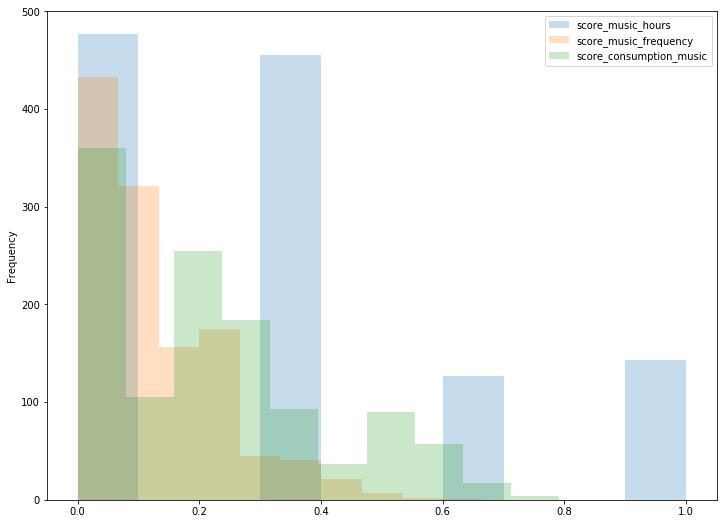

In [197]:
[(ds.data[a].plot.hist(alpha = 0.25, legend = True)) for a in ['score_music_hours', 'score_music_frequency', 'score_consumption_music']];

#### Heritage

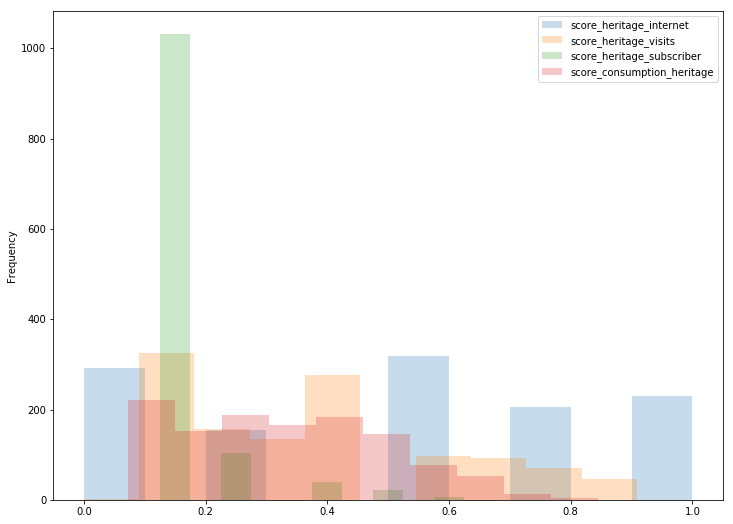

In [198]:
[(ds.data[a].plot.hist(alpha = 0.25, legend = True)) for a in ['score_heritage_internet', 'score_heritage_visits', 'score_heritage_subscriber', 'score_consumption_heritage']];

#### Art

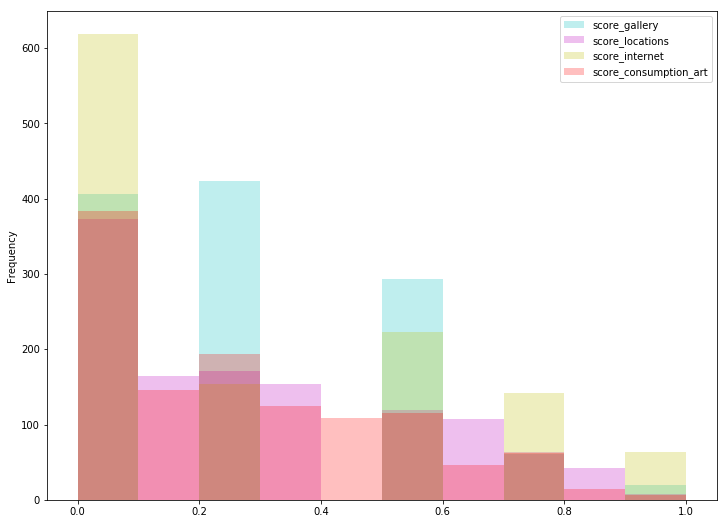

In [199]:

[(ds.data[a].plot.hist(alpha = 0.25, legend = True, color = colours[i])) for i, a in enumerate(['score_gallery', 'score_locations', 'score_internet', 'score_consumption_art'])];

#### Literature

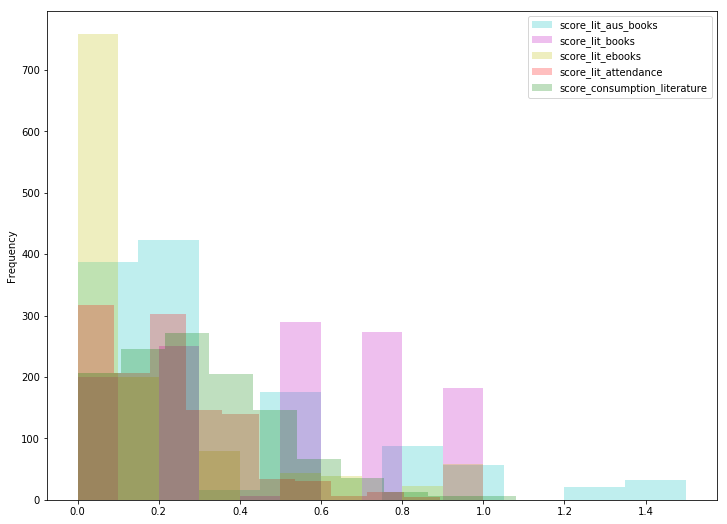

In [201]:
[(ds.data[a].plot.hist(alpha = 0.25, legend = True, color = colours[i])) for i, a in enumerate(['score_lit_aus_books', 
                                                                                                'score_lit_books', 
                                                                                                'score_lit_ebooks', 
                                                                                                'score_lit_attendance', 
                                                                                                'score_consumption_literature'])];



#### Television

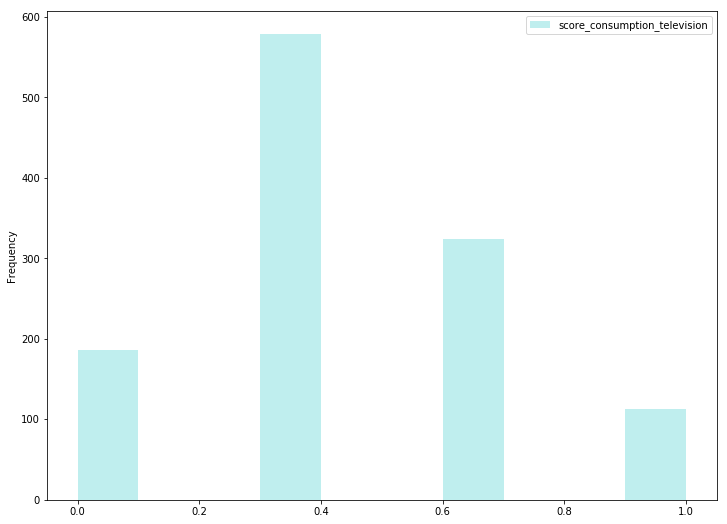

In [202]:
[(ds.data[a].plot.hist(alpha = 0.25, legend = True, color = colours[i])) for i, a in enumerate(['score_consumption_television'])];



#### Sport

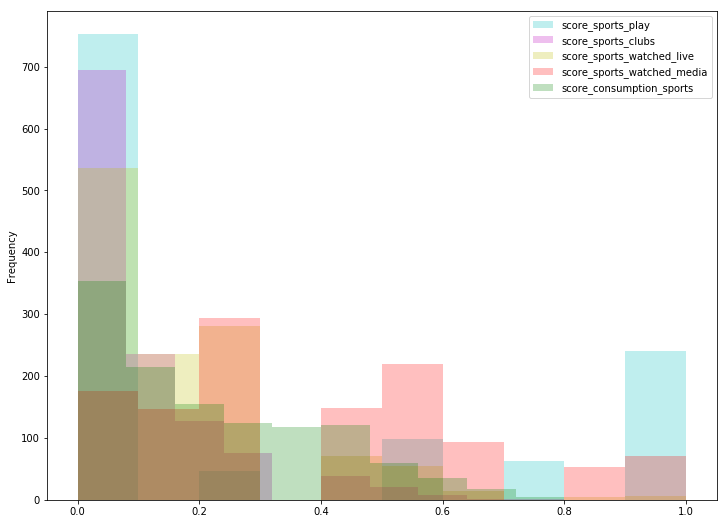

In [203]:
[(ds.data[a].plot.hist(alpha = 0.25, legend = True, color = colours[i])) for i, a in enumerate(['score_sports_play', 
                                                                                                'score_sports_clubs', 
                                                                                                'score_sports_watched_live', 
                                                                                                'score_sports_watched_media', 
                                                                                                'score_consumption_sports'])];



#### All Fields

In [207]:
cols_consumption = ['score_consumption_music', 
                    'score_consumption_heritage', 
                    'score_consumption_art', 
                    'score_consumption_literature', 
                    'score_consumption_television', 
                    'score_consumption_sports']

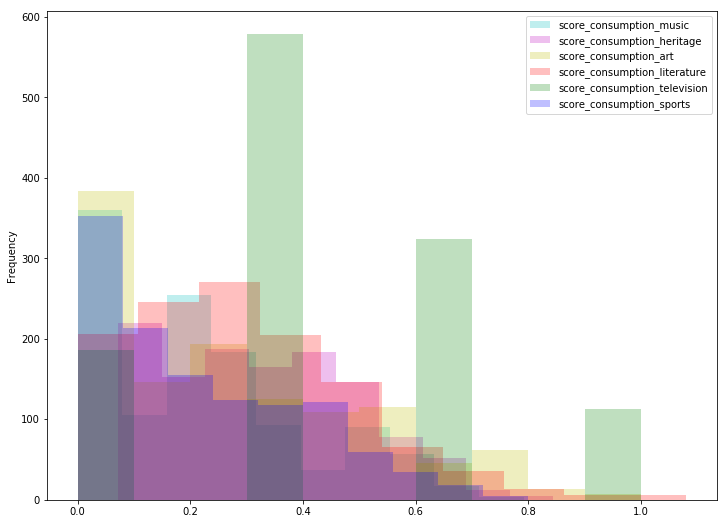

In [208]:
[(ds.data[a].plot.hist(alpha = 0.25, legend = True, color = colours[i])) for i, a in enumerate(cols_consumption)];



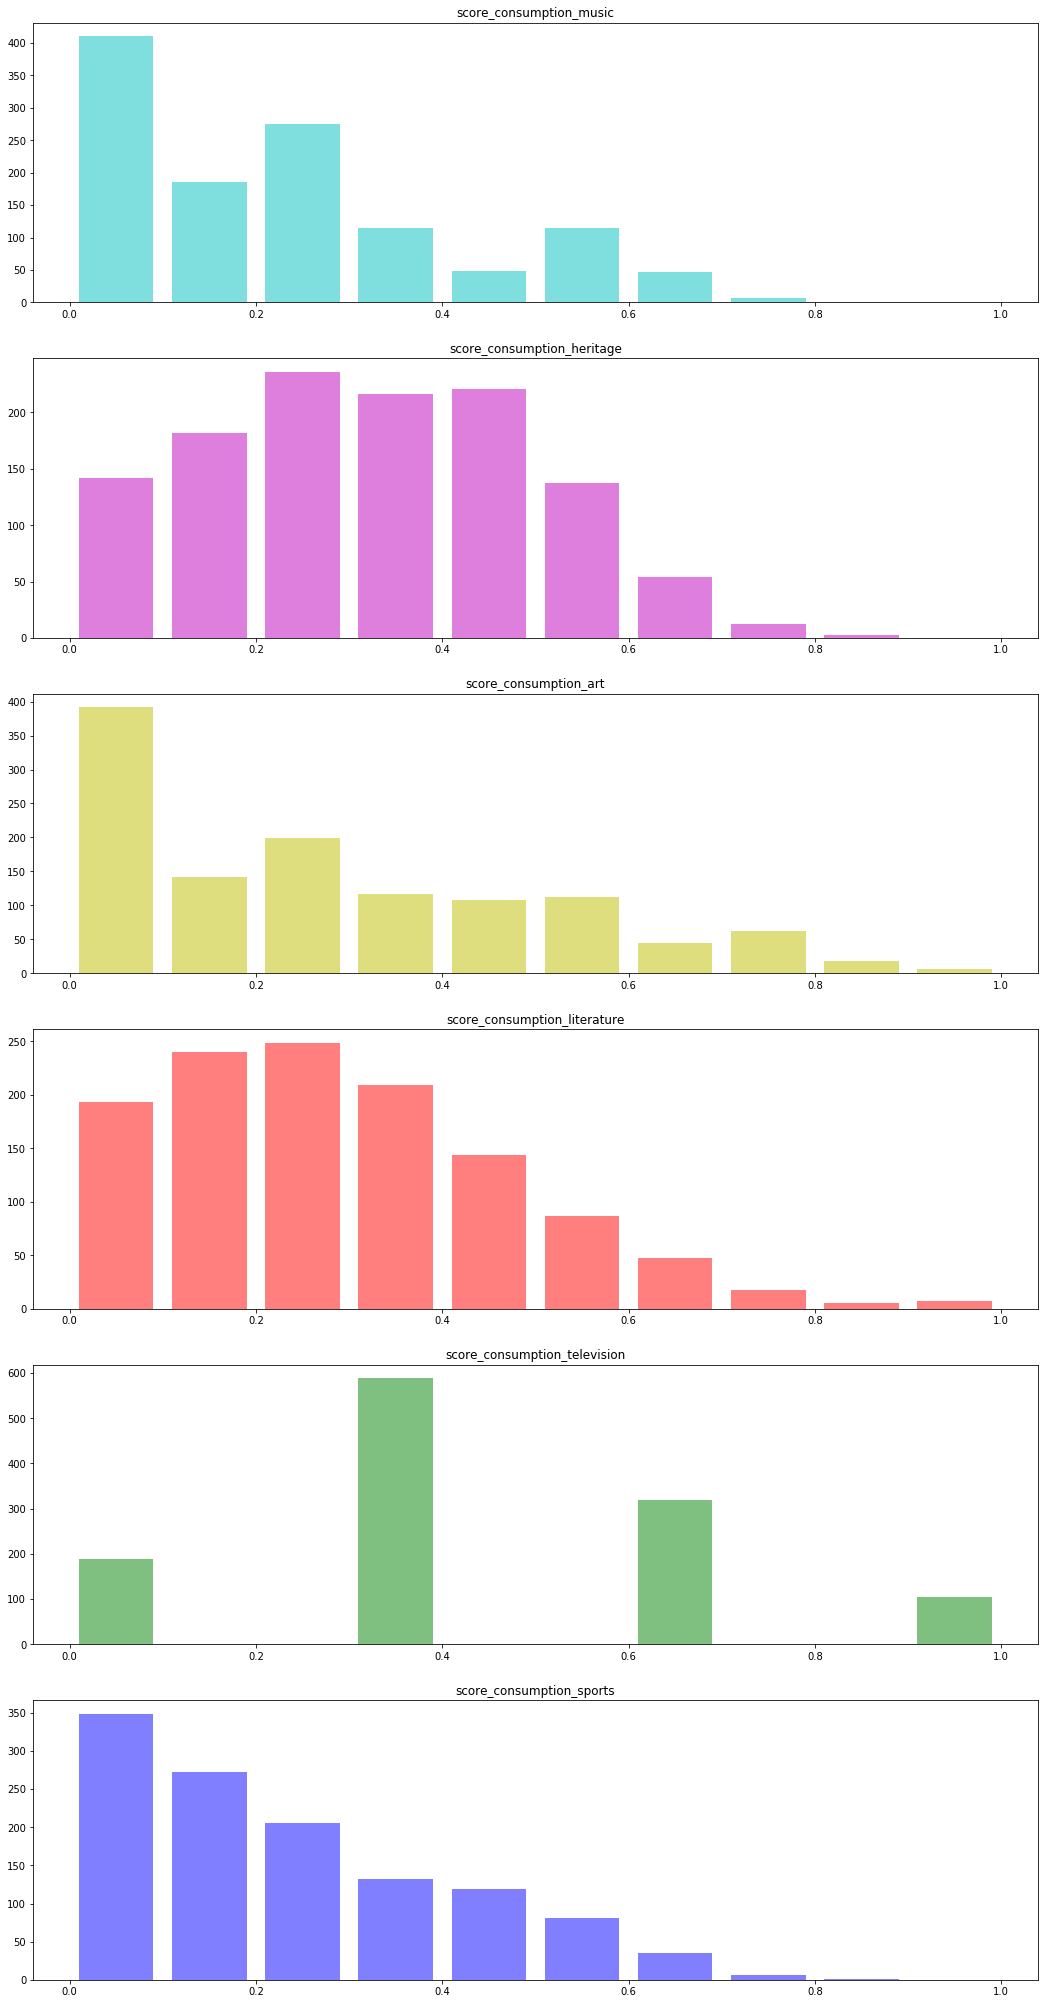

In [209]:
nrows, ncols = 6, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 36))
counter = 0

for i in range(nrows):
    for j in range(ncols):
        if ncols > 1:
            ax = axes[i][j]
        else:
            ax = axes[i]
        if counter < len(cols_consumption):
            col = cols_consumption[counter]
            dg = ds.data[[col, 'WEIGHT']].dropna()
            ax.hist(dg[col], weights = dg['WEIGHT'], range = (0., 1.), bins=10, alpha=0.5, rwidth = 0.8, width = 0.08, color = colours[counter])
            ax.set_title(col)
        else:
            ax.set_axis_off()
        counter += 1
plt.show()
        


No handles with labels found to put in legend.


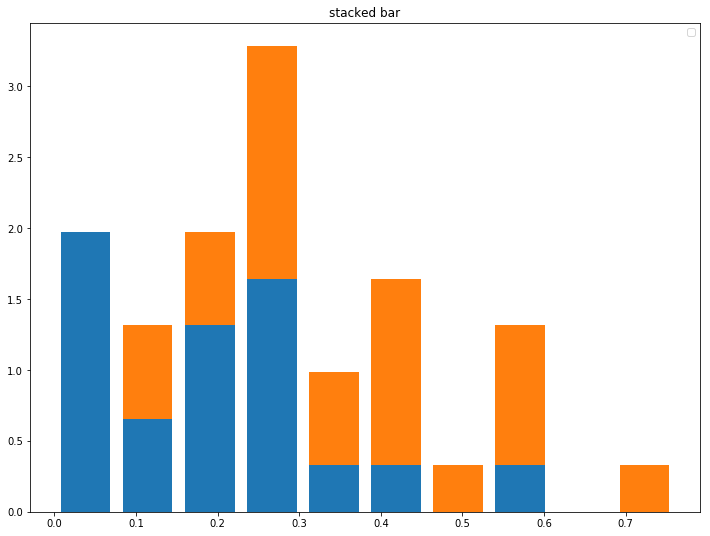

In [210]:
ax = plt.subplot(111)


colors = ['red', 'tan', 'lime']

n_bins = 10
ax.hist(ds.data[cols_consumption[0:2]][0:20].as_matrix(), n_bins, density=True, stacked = True, histtype='bar', rwidth = 0.8)
#ax.hist(x, width = 0.08, density=True, bins = n_bins, stacked = True, range=(0., 1.))
ax.set_title('stacked bar')
ax.legend()

fig.tight_layout()
plt.show()

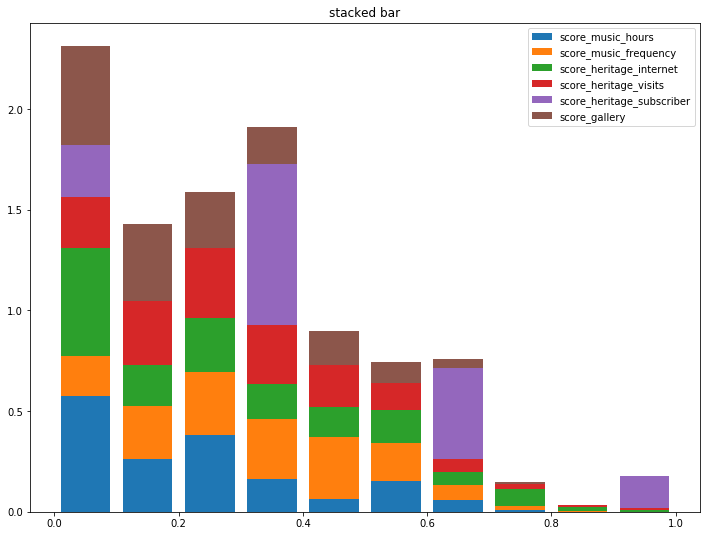

In [211]:
ax = plt.subplot(111)


colors = ['red', 'tan', 'lime']

n_bins = 10
ax.hist(ds.data[cols_consumption].as_matrix(), n_bins, density=True, stacked = True, histtype='bar', rwidth = 0.8, label = cols, range = (0., 1.))
ax.set_title('stacked bar')
ax.legend()

fig.tight_layout()
plt.show()

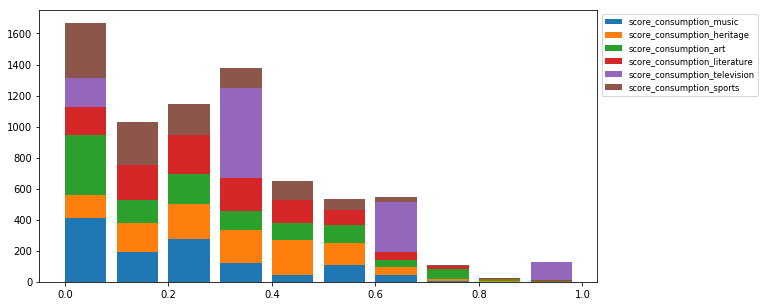

In [218]:
f, ax = plt.subplots(1, figsize=(10,5))
bottom = np.zeros(10).astype('float')

for i, col in enumerate(cols_consumption):
    dat, r = np.histogram(ds.data[col], bins = 10, range = (0., 1.))
    ax.bar(r[:-1], dat, bottom = bottom, width = 0.08, label=col, align = 'edge')
    bottom += dat

ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1, fontsize='small');


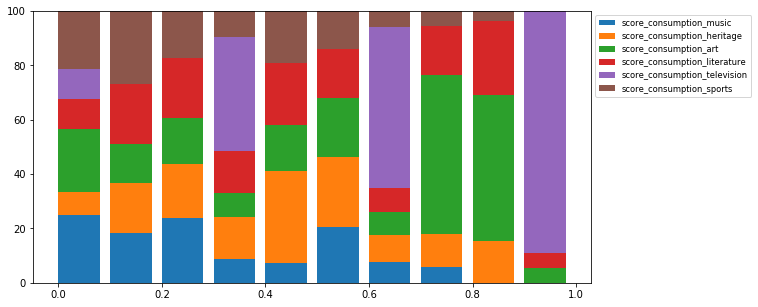

In [219]:
f, ax = plt.subplots(1, figsize=(10,5))
bottom = np.zeros(10).astype('float')

all, r = np.histogram(ds.data[cols_consumption], bins = 10, range = (0., 1.))
for i, col in enumerate(cols_consumption):
    dat, r = np.histogram(ds.data[col], bins = 10, range = (0., 1.))
    percents = 100 * dat / all
    ax.bar(r[:-1], percents, bottom = bottom, width = 0.08, label=col, align = 'edge')
    bottom += percents

ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1, fontsize='small');


### Frequencies

In [220]:
ds.freq_table('sex')

,sex,Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
0.0,Men,568,47.3,592.663212,49.3
1.0,Women,634,52.7,609.535945,50.7


In [221]:
ds.freq_table('soc8cla')

,NS-SEC soc2010 8 social classes,Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,Large owners/high man,45,3.7,51.573241,4.3
2.0,High professional,143,11.9,144.405417,12.0
3.0,Lower man/prof,378,31.4,374.868982,31.2
4.0,Intermediate occup,113,9.4,114.149986,9.5
5.0,Small employer/own account,142,11.8,137.638006,11.4
6.0,Low superv/technical,89,7.4,89.298490,7.4
7.0,Semi-routine,161,13.4,160.932157,13.4
8.0,Routine,91,7.6,88.742395,7.4
9.0,Never worked,24,2.0,21.579622,1.8


In [222]:
ds.freq_table('spaloc')

,Place of residence,Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,Inner city,112,9.3,104.807143,8.7
2.0,Suburban,557,46.3,577.453208,48.0
3.0,Small town,256,21.3,243.958793,20.3
4.0,Semi-rural,154,12.8,148.294184,12.3
5.0,Rural/remote,122,10.1,126.860716,10.6
6.0,dk place residence,1,0.1,0.825113,0.1


In [223]:
ds.freq_table('Q24')

,How many hours a day do you normally spend listening to music?,Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,Less than 1 hour,477,39.7,470.791904,39.2
2.0,1-3 hours,453,37.7,452.945617,37.7
3.0,Over 3 hours but less than 5 hours,127,10.6,124.698105,10.4
4.0,5 hours or more,143,11.9,151.617421,12.6


In [224]:
ds.freq_table('Q25')

,How do you most often listen to music? Would you sayâ€¦,Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,On the radio,594,49.4,594.293427,49.4
2.0,On a CD player,166,13.8,142.676199,11.9
3.0,"On a computer (desktop, laptop)",139,11.6,148.319071,12.3
4.0,"On a mobile device (phone, iPod, iPad, mp3 pla...",264,22.0,280.082771,23.3
5.0,"On a record player (vinyl records, LPs)",13,1.1,12.348269,1.0
6.0,On a MiniDisk or cassette player,10,0.8,9.038901,0.8
7.0,On live instruments,7,0.6,7.729903,0.6


In [225]:
ds.freq_table('Q37')

,"How often do you use the internet to search for information on heritage places or events (such as visiting museum collections and exhibitions online, investigating family histories using online tools, or reading about historical events online)?",Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,Once a week or more,230,19.1,228.771936,19.0
2.0,About once a month,206,17.1,202.720085,16.9
3.0,A few times a year,319,26.5,336.546140,28.0
4.0,About once a year,154,12.8,150.961939,12.6
5.0,Never,293,24.4,283.199057,23.6


In [226]:
ds.freq_table('Q49')

,Approximately how many books by Australian authors have you read for your own interest or pleasure over the past year?,Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,None,387,32.2,417.835215,34.8
2.0,1-3,424,35.3,424.111626,35.3
3.0,4-6,176,14.6,164.322974,13.7
4.0,7-10,88,7.3,82.484932,6.9
5.0,11-20,57,4.7,49.537307,4.1
6.0,21-30,21,1.7,17.665795,1.5
7.0,More than 30,33,2.7,31.532037,2.6
8.0,"{Font color=""silver""}Don't know - Do not read ...",10,0.8,8.845524,0.7


In [227]:
ds.freq_table('Q50')

,Approximately how many books are there in your home?,Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,Less than 50,200,16.6,206.990678,17.2
2.0,50 to 100,251,20.9,263.199287,21.9
3.0,101 to 200,289,24.0,290.189864,24.1
4.0,201 to 500,274,22.8,267.256941,22.2
5.0,501 or more,182,15.1,168.698638,14.0


In [228]:
ds.freq_table('Q51')

,How many e-books do you personally own?,Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,None,759,63.1,745.346340,62.0
2.0,Less than 10,194,16.1,199.855245,16.6
3.0,10 to 25,80,6.7,79.310200,6.6
4.0,26 to 50,44,3.7,45.497469,3.8
5.0,51 to 100,38,3.2,40.394367,3.4
6.0,101 to 200,22,1.8,20.835675,1.7
7.0,More than 200,59,4.9,65.096113,5.4


In [229]:
ds.freq_table('Q56')

,How often you take part in or attend cultural activities from cultural backgrounds other than your own? This includes both attending events and more active forms of participation.,Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,Once a week or more,17,1.4,15.912743,1.3
2.0,About once a month,45,3.7,45.488630,3.8
3.0,A few times a year,335,27.9,345.540293,28.7
4.0,About once a year,339,28.2,337.745181,28.1
5.0,Never,466,38.8,457.512310,38.1


In [307]:
ds.freq_table('Q92')

,"Approximately how much capital would you say you have invested in savings, bonds, shares, or superannuation funds, for example, and in house contents, vehicles, land, or a second property?",Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,"Under $10,000",157,13.1,149.379172,12.4
2.0,"$10,000 - $24,999",87,7.2,91.264619,7.6
3.0,"$25,000 - $49,999",100,8.3,110.842362,9.2
4.0,"$50,000 - $99,999",142,11.8,155.810264,13.0
5.0,"$100,000 - $199,999",141,11.7,154.165129,12.8
6.0,"$200,000 - $499,999",157,13.1,163.433780,13.6
7.0,"$500,000 - $1 million",107,8.9,98.923996,8.2
8.0,More than $1 million,78,6.5,70.774414,5.9
9.0,Don't know / refused (Do not read out),233,19.4,207.605421,17.3


In [308]:
ds.freq_table('Q89')

,"What is your total annual household income from all sources including salaries, wages, pensions, superannuation, rent, interest, dividends and benefits, before tax is taken out? Is itâ€¦",Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,"Less than $15,000",27,2.2,26.477251,2.2
2.0,"$15,000 - $29,999",123,10.2,108.437120,9.0
3.0,"$30,000 - $39,999",71,5.9,66.637413,5.5
4.0,"$40,000 - $59,999",126,10.5,125.688161,10.5
5.0,"$60,000 - $79,999",135,11.2,136.115764,11.3
6.0,"$80,000 - $99,999",133,11.1,138.853076,11.5
7.0,"$100,000 - $149,999",183,15.2,200.647922,16.7
8.0,"$150,000 - $199,999",102,8.5,108.677557,9.0
9.0,"$200,000 - $299,999",56,4.7,68.359516,5.7


### Postcodes

In [230]:
postcodes = pd.read_csv("data/POA_2016_AUST.csv")

/home/ubuntu/anaconda3/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### ABS LGAs

In [231]:
names = ["POSTCODE",
            "CODE_2011",
            "NAME_2011",
            "RATIO",
            "PERCENTAGE"]

def readStatisticalAreas(file):
    sas = pd.read_csv(file, encoding = "ISO-8859-1")
    sas = sas.iloc[5:3115, 0:5]
    sas.columns = names
    sas = sas.iloc[3:3107,1:4]
    return sas

lgas = readStatisticalAreas("data/1270055006_CG_POSTCODE_2011_LGA_2011.csv")

In [232]:
lgas.iloc[1,:]

CODE_2011          0812
NAME_2011         71000
RATIO        Darwin (C)
Name: 9, dtype: object

### SEIFA 


In [233]:
seifa_raw = pd.read_excel('./data/2033.0.55.001 POA Indexes.xls', sheet_name = 1)
seifa = seifa_raw.iloc[5:2487, 0:10]
seifa.columns = [ "postcode", "score_adv_disadv", "decile_adv_disadv", "score_disadv", "decile_disadv", "score_eco_resource", "decile_eco_resource", "score_edu_occ", "decile_edu_occ", "res_pop"]



In [234]:
seifa[['score_adv_disadv', 'score_disadv', 'score_eco_resource', 'score_edu_occ']] = seifa[['score_adv_disadv', 'score_disadv', 'score_eco_resource', 'score_edu_occ']].apply(lambda x: pd.to_numeric(x, errors='coerce'))


In [235]:
seifa.tail()

,postcode,score_adv_disadv,decile_adv_disadv,score_disadv,decile_disadv,score_eco_resource,decile_eco_resource,score_edu_occ,decile_edu_occ,res_pop
2482,7331,957.614384,4,979.521477,5,961.753295,3,969.995993,5,483
2483,7467,871.238186,1,882.214804,1,888.986183,1,854.022366,1,1979
2484,7468,942.713765,3,967.011158,4,965.852320,3,900.802483,2,661
2485,7469,884.917332,1,902.700477,1,947.433962,2,824.308759,1,930
2486,7470,878.343904,1,889.146901,1,912.788410,1,860.066938,1,920


### Geographical Data

In [236]:
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon

In [237]:
d = gpd.read_file("./data/1270055003_poa_2016_aust_shape/POA_2016_AUST.dbf")

In [238]:
d = d[d.geometry.notna()]

In [239]:
d.head()

,POA_CODE16,POA_NAME16,AREASQKM16,geometry
0,0800,0800,3.1734,"POLYGON ((130.834539712 -12.45798405399995, 13..."
1,0810,0810,23.7902,POLYGON ((130.8471142530001 -12.37754403699995...
2,0812,0812,35.8899,POLYGON ((130.8919169080001 -12.36878576699996...
3,0815,0815,0.6381,"POLYGON ((130.872398607 -12.37654838499998, 13..."
4,0820,0820,39.0462,"POLYGON ((130.834991691 -12.43006229899993, 13..."


In [240]:
d['centroids'] = d.geometry.centroid
d['centroids_x'] = d.geometry.centroid.x
d['centroids_y'] = d.geometry.centroid.y
d['postcode'] = d.POA_CODE16

In [241]:
d['geom_sim'] = d.simplify(.001, preserve_topology = True)

#### Create Sydney Data

In [242]:
cbd = d.loc[d.POA_CODE16 == "2000", ].centroids

In [249]:
syd = ["2000", "2006", "2007", "2008", "2009", "2010", "2011", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2032", "2035", "2036", "2037", "2038", "2039", "2040", "2041", "2042", "2043", "2044", "2048", "2049", "2050", "2203", "2204",  
        "2021", "2022", "2023", "2024", "2025", "2026", "2027", "2028", "2029", "2030", "2031", "2032", "2033", "2034", "2035", "2036",  
        "2172", "2205", "2207", "2208", "2209", "2210", "2216", "2217", "2218", "2219", "2220", "2221", "2222", "2223", "2224", "2225", "2226", "2227", "2228", "2229", "2230", "2231", "2232", "2233", "2234",  
        "2133", "2143", "2161", "2162", "2163", "2190", "2191", "2192", "2193", "2194", "2195", "2196", "2197", "2198", "2199", "2200", "2206", "2208", "2209", "2210", "2211", "2212", "2213", "2214", 
        "2161", "2163", "2164", "2165", "2166", "2168", "2170", "2171", "2172", "2173", "2174", "2175", "2176", "2177", "2178", "2179", "2555", "2556", "2557", "2565", "2745", 
        "2167", "2174", "2179", "2557", "2558", "2559", "2560", "2563", "2564", "2565", "2566", "2567", "2568", "2569", "2570", "2571", "2572", "2573", "2574", "2745", "2752", "2787", 
        "2045", "2046", "2047", "2130", "2131", "2132", "2133", "2134", "2135", "2136", "2137", "2138", "2140", "2190", "2191", "2193", 
        "2115", "2116", "2117", "2118", "2121", "2122", "2127", "2128", "2140", "2141", "2142", "2143", "2144", "2145", "2146", "2148", "2150", "2151", "2152", "2153", "2160", "2161", "2162", "2164", 
        "2178", "2745", "2747", "2748", "2749", "2750", "2753", "2754", "2755", "2756", "2757", "2758", "2759", "2760", "2765", "2773", "2774", "2775", "2776", "2777", "2778", "2779", "2780", "2782", "2783", "2784", "2785", "2786", 
        "2146", "2147", "2148", "2155", "2760", "2761", "2762", "2763", "2765", "2766", "2767", "2768", "2770", 
        "2060", "2061", "2062", "2063", "2064", "2065", "2066", "2067", "2068", "2069", "2088", "2089", "2090", "2109", "2110", "2111", "2112", "2113", "2114", "2122", 
        "2069", "2070", "2071", "2072", "2073", "2074", "2075", "2076", "2077", "2079", "2080", "2081", "2082", "2083", "2117", "2118", "2119", "2120", "2121", "2122", "2125", "2126", "2151", "2152", "2153", "2154", "2155", "2156", "2157", "2158", "2159", "2756", "2765", "2775", 
        "2084", "2085", "2086", "2087", "2092", "2093", "2094", "2095", "2096", "2097", "2099", "2100", "2101", "2102", "2103", "2104", "2105", "2106", "2107", "2108", 
        "2083", "2250", "2251", "2256", "2257", "2258", "2259", "2260", "2261", "2262", "2263", "2775"]

In [259]:
ds_syd = ds.data[ds.data.Q4.isin(syd)]
ds_syd = ds_syd.assign(Q4 = ds_syd.Q4.astype('int32'))

In [260]:
seifa_syd = seifa[seifa.postcode.isin(map(int, syd))]
seifa_syd.set_index(seifa_syd.postcode.astype('int32'), drop = True, inplace = True)

#### Sydney geometry

In [261]:
d_syd = d[d.POA_CODE16.isin(syd)]
d_syd = d_syd.assign(dist_to_cbd = [c.distance(cbd.iloc[0]) for c in d_syd.centroids],
                     dist_to_cbd_lon = [np.abs(cbd.iloc[0].x - c.x) for c in d_syd.centroids],
                     dist_to_cbd_lat = [np.abs(cbd.iloc[0].y - c.y) for c in d_syd.centroids])
d_syd.set_index(d_syd.POA_CODE16.astype('int32'), drop = True, inplace = True)

#### Add weighted averages

In [262]:
score_vars = [x for x in ds.data.columns if 'score_' in x]
score_vars = cols_consumption

In [263]:
# Arts
# score_gallery_avg = acf_syd.groupby('Q4').apply(lambda x: np.average(x['score_gallery'], weights = x.WEIGHT) )
# score_locations_avg = acf_syd.groupby('Q4').apply(lambda x: np.average(x['score_locations'], weights = x.WEIGHT) )
# score_internet_avg = acf_syd.groupby('Q4').apply(lambda x: np.average(x['score_internet'], weights = x.WEIGHT) )
# score_art_consumption_avg = acf_syd.groupby('Q4').apply(lambda x: np.average(x['score_art_consumption'], weights = x.WEIGHT) )

values = ([ds_syd.groupby('Q4').apply(lambda x: np.average(x[y], axis = 0, weights = x.WEIGHT)) for y in score_vars])
index = values[0].index
poa_means = pd.DataFrame(np.array(values).T, index = index, columns = score_vars)


#### Merge data sets

In [264]:
d_syd = d_syd.merge(poa_means, how = 'left', left_index = True, right_index = True)
d_syd = d_syd.merge(seifa_syd, how = 'left', left_index = True, right_index = True)

## Density

Add [GDAL](http://www.gdal.org/) imports.

In [265]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr


Load Australia's [2016 population densities](http://www.abs.gov.au/ausstats/abs@.nsf/Previousproducts/3218.0Main%20Features702015-16?opendocument&tabname=Summary&prodno=3218.0&issue=2015-16&num=&view=), supplied by ABS. These figures are derived from "estimated residential populations" measured in $1km^2$ grid cells, which they term Australian Population Grid (APG). ABS refers to these as Australian Population Grid. Pre-computed average densities are available in KML format for LGA and SA2 but not for postcode levels. 

The steps below compute average and maximum densities for postcodes. It uses the ESRI Shapefile format, available on the ABS's APG [Downloads](http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/3218.02015-16?OpenDocument) page.



In [266]:
#apg_src = gdal.Open("./data/apg_2016/apg16e_1_0_0/", gdal.GA_ReadOnly)
apg_src = gdal.Open("./data/apg1617e_1", gdal.GA_ReadOnly)


Check the transformation data. Details obtained from <http://geoinformaticstutorial.blogspot.com.au/2012/09/reading-raster-data-with-python-and-gdal.html>.

In [267]:
geotransform = apg_src.GetGeoTransform() 
print("top left x :", geotransform[0]) # top left x 
print("w-e pixel resolution :", geotransform[1]) # w-e pixel resolution 
print("rotation, 0 if image is 'north up' :", geotransform[2]) # rotation, 0 if image is "north up" 
print("top left y :", geotransform[3]) # top left y 
print("rotation, 0 if image is 'north up' :", geotransform[4]) # rotation, 0 if image is "north up" 
print("n-s pixel resolution *:", geotransform[5]) # n-s pixel resolution *
    

top left x : -3901000.0
w-e pixel resolution : 1000.0
rotation, 0 if image is 'north up' : 0.0
top left y : -1000000.0
rotation, 0 if image is 'north up' : 0.0
n-s pixel resolution *: -1000.0


Print the minimum and maximum grid coordinates.

In [268]:
minx = geotransform[0]
miny = geotransform[3]
stepx = geotransform[1]
stepy = geotransform[5]
maxx = minx + geotransform[1] * apg_src.RasterXSize
maxy = miny + geotransform[5] * apg_src.RasterYSize

print("Projection details (minimum): ", (minx, miny))
print("Step details: ", (stepx, stepy))
print("Projection details (maximum): ", (maxx, maxy))

Projection details (minimum):  (-3901000.0, -1000000.0)
Step details:  (1000.0, -1000.0)
Projection details (maximum):  (3500000.0, -5100000.0)


Print the grid's projection details.

In [269]:
prj_wkt = apg_src.GetProjection()
print("Projection details: ", prj_wkt)

Projection details:  PROJCS["unnamed",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["METERS",1]]


Print the number of bands in the raster file.

In [270]:
print("[ RASTER BAND COUNT ]: ", apg_src.RasterCount)

[ RASTER BAND COUNT ]:  1


Print details about the first (and what should be the only) raster band.

In [271]:
srcband = apg_src.GetRasterBand(1)

In [272]:
print("[ NO DATA VALUE ] = ", srcband.GetNoDataValue())
print("[ MIN ] = ", srcband.GetMinimum())
print("[ MAX ] = ", srcband.GetMaximum())
print("[ SCALE ] = ", srcband.GetScale())
print("[ UNIT TYPE ] = ", srcband.GetUnitType())

[ NO DATA VALUE ] =  -3.4028234663852886e+38
[ MIN ] =  0.0
[ MAX ] =  25743.07421875
[ SCALE ] =  1.0
[ UNIT TYPE ] =  


Define the start (X,Y) - North and West - coordinates for Sydney, and read in the following $100^2 (= 10,000)$ cells. For rendering purposes, values less than zero are replaced with zeros. 

The furthermost East coordinates should have zero densities -- they should be in the ocean!

In [273]:
start_x, start_y = 5583, 2763
pxls = srcband.ReadAsArray(start_x, start_y, 100, 100).astype(np.float)
pxls[pxls < 0] = 0

print("North West corner density: ", pxls[0,0])
print("North East corner density: ", pxls[0,99])
print("South West corner density: ", pxls[99,0])
print("South East corner density: ", pxls[99,99])

North West corner density:  0.0
North East corner density:  2.0
South West corner density:  0.0
South East corner density:  0.0


Free up resources.

In [274]:
# apg_src = None
# srcband = None

Plot the densities.

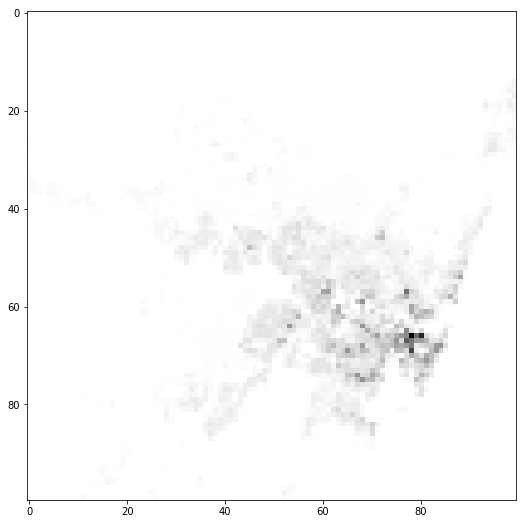

In [275]:
im = pxls
im[im == -3.4028234663852886e+38] = 0
plt.imshow(im, cmap=plt.cm.Greys,vmin = 0,vmax = np.max(pxls));

Develop transformations to and from the ABS Shapefile representation and longitude/latitude.

Formats are defined by [EPSG](http://www.epsg.org/) (European Petroleum Survey Group). 

In [276]:
# Add the points
points = []
for i in range(pxls.shape[1]):
    for j in range(pxls.shape[0]):
        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(minx + start_x * stepx + j*1000, miny + start_y * stepy + i * stepy, pxls[i, j])
        points.append(point)

# Convert to Numpy array
points = np.array(points)

# The existing projection
inSpatialRef = osr.SpatialReference(wkt=prj_wkt)

# The standard long./lat. format
outputEPSG = 4326
outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(outputEPSG)

# In -> Out
forwardTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
# Out -> In
backTransform = osr.CoordinateTransformation(outSpatialRef, inSpatialRef)

# Functions mapping forward and back
def f(pt):
    return pt.Transform(forwardTransform)

def b(pt):
    return pt.Transform(backTransform)

# # An alternative vectorised form - for now, not working
# transformer = lambda pt: pt.Transform(coordTransform)
# vfunc = np.vectorize(f)

# Test forward and back
print("Initial point: ", points[0])

# Comprehension conversion: forward
[f(pt) for pt in points]
print("Converted point: ", points[0])

# Comprehension conversion: Back
[b(pt) for pt in points]
print("Converted back (= initial): ", points[0])



Initial point:  POINT (1682000 -3763000 0)
Converted point:  POINT (150.257964413073 -33.3893008025616 0)
Converted back (= initial):  POINT (1682000.0 -3763000.0 0)


Retrieve points from the geometry.

In [277]:
from shapely.geometry import shape, mapping, Point
points_sim = np.array([p.GetPoint() for p in points])
print("Simplified point representation:", points_sim[0]) 

Simplified point representation: [ 1682000. -3763000.        0.]


Convert point array back into a *map height x width* representation. This will make calculating mean and maximum densities for postcode shapes easier.

In [278]:
points_shp = np.reshape(points_sim, (pxls.shape[1], pxls.shape[0], 3))
print("Shape of points_shp:", points_shp.shape)
xmin, ymin, _ = points_shp[0, 0]
print("NW coordinates: ", (xmin, ymin))
xmax, ymax, _ = points_shp[99, 99]
print("SE coordinates: ", (xmax, ymax))


Shape of points_shp: (100, 100, 3)
NW coordinates:  (1682000.0000000005, -3762999.9999999977)
SE coordinates:  (1780999.9999999993, -3862000.000000002)


First, create a 2-dimensional array, where the first dimension is equal to the number of Sydney postcodes.

Then, iterate through each of the postcode shapes, and add all point values (representing $1km^2$ residential population) within those shapes to the corresponding arrays.

As an optimisation, only points within the rectangular bounds of the shapes are tested for whether they belong to the shapes themselves.

In [279]:
d_pts = [[] for i in range(len(d_syd))]

for i in range(len(d_syd)):
    # Obtain the bounds
    gxmin, gymin, gxmax, gymax = d_syd.iloc[i].geom_sim.bounds
    # Convert the bounds to the ESPG format of the population grid.
    gmin = ogr.Geometry(ogr.wkbPoint)
    gmin.AddPoint(gxmin, gymin)
    b(gmin)
    gmin = gmin.GetPoint()
    gmax = ogr.Geometry(ogr.wkbPoint)
    gmax.AddPoint(gxmax, gymax)
    b(gmax)
    gmax = gmax.GetPoint()
    # Obtain the offsets into the grid representation itself
    xomin = int(np.round((gmin[0] - xmin) / stepx))
    xomax = int(np.round((gmax[0] - xmin)  / stepx))
    yomin = int(np.round((gmax[1] - ymin) / stepy))
    yomax = int(np.round((gmin[1] - ymin) / stepy))
    # Slice the 2-dimensional APG representation, and for ease of iteration, flatten to a (10,000, 3) array.
    lpts = points_shp[yomin:yomax+1, xomin:xomax+1, :]
    lpts = (np.reshape(lpts, (lpts.shape[0] * lpts.shape[1],3)))
    
    # Iterate through the point to test for inclusion with this shape.
    for pt in lpts:
        pt0 = ogr.Geometry(ogr.wkbPoint)
        pt0.AddPoint(pt[0], pt[1])
        # This time, convert the grid representation to the postcode shapefile representation.
        f(pt0)
        pt_sim = Point(pt0.GetPoint()[0], pt0.GetPoint()[1])
        # Test whether the point belongs to the postcode, and add it to the array if so.
        if pt_sim.within(d_syd.iloc[i].geom_sim):
            # Ignore the coordinates - just append the value
            d_pts[i].append(pt[2])


Convert the resulting array to a Numpy equivalent, and obtain mean and maximum values.

In [373]:
d_pts = [[0] if len(x) == 0 else x for x in d_pts]
d_pts = np.array(d_pts)
pt_mns = np.array([np.nanmean(x) for x in d_pts])
pt_mxs = np.array([np.nanmax(x) for x in d_pts])
print("Maximum postcode mean: ", max(pt_mns))
print("Minimum postcode mean: ", min(pt_mns))

print("Maximum postcode max: ", max(pt_mxs))
print("Minimum postcode max: ", min(pt_mxs))



Maximum postcode mean:  12532.953125
Minimum postcode mean:  0.0
Maximum postcode max:  20384.599609375
Minimum postcode max:  0.0


An alternative and simpler version. Not working, as none of the EPSG codes reported in the projection are found.

In [281]:
# from pyproj import Proj, transform

# inProj = Proj(init='epsg:7019')
# outProj = Proj(init='epsg:4326')
# x1,y1 = -3853000.0,-1012000.0
# x2,y2 = transform(inProj,outProj,x1,y1)
# print(x2,y2)

Add densities to data structure.

In [282]:
d_syd = d_syd.assign(density = pt_mns)

Normalise densities and log of densities.

In [283]:
pt_mns_norm = (pt_mns + 1.)  / np.max((pt_mns + 1.))
pt_mns_norm_log = np.log(pt_mns + 1.)  / np.max(np.log(pt_mns + 1.))

Plots the normalised densities.

(-34.55346495499998, -33.00032154199994)

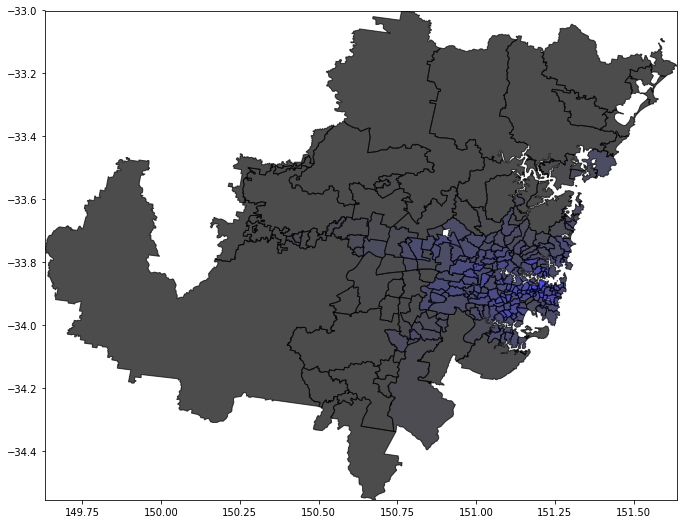

In [338]:
from descartes.patch import PolygonPatch

plt.figure()
ax = plt.axes()
ax.set_aspect('equal')

# build the polygon from exterior points
bounds = d_syd.geometry.bounds
for i in range(len(d_syd.geom_sim)):
    p = d_syd.iloc[i].geom_sim
    intensity = pt_mns_norm[i]
    patch = PolygonPatch(p, facecolor=[0,0,intensity], edgecolor=[0,0,0], alpha=0.7, zorder=2)
    ax.add_patch(patch)

# use bbox (bounding box) to set plot limits
plt.xlim(np.min(bounds.minx),np.max(bounds.maxx))
plt.ylim(np.min(bounds.miny),np.max(bounds.maxy))


Plots the normalised log densities.

(-34.55346495499998, -33.00032154199994)

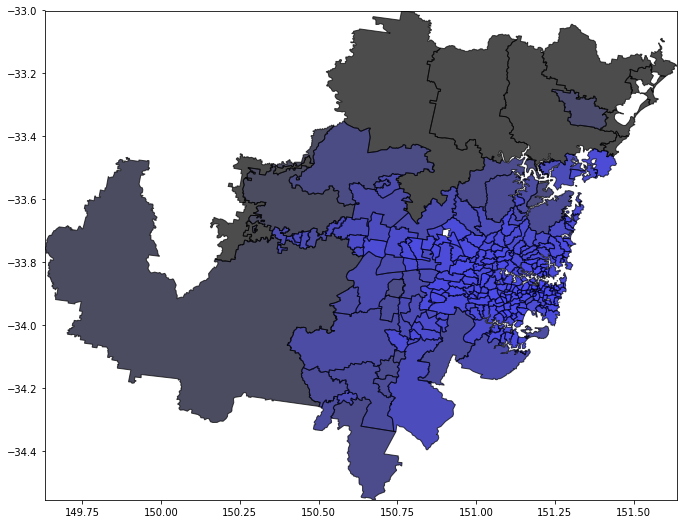

In [285]:
plt.figure()
ax = plt.axes()
ax.set_aspect('equal')

# build the polygon from exterior points
bounds = d_syd.geometry.bounds
for i in range(len(d_syd.geom_sim)):
    p = d_syd.iloc[i].geom_sim
    intensity = pt_mns_norm_log[i]
    patch = PolygonPatch(p, facecolor=[0,0,intensity], edgecolor=[0,0,0], alpha=0.7, zorder=2)
    ax.add_patch(patch)

# use bbox (bounding box) to set plot limits
plt.xlim(np.min(bounds.minx),np.max(bounds.maxx))
plt.ylim(np.min(bounds.miny),np.max(bounds.maxy))


In [286]:
ds.data.to_csv('data/acf.csv')

### Initial Graphs

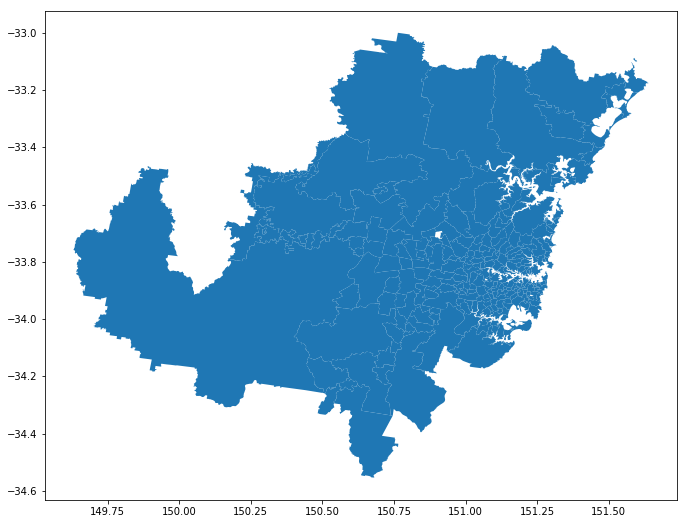

In [287]:
gpd.GeoSeries(d_syd.geometry).plot();

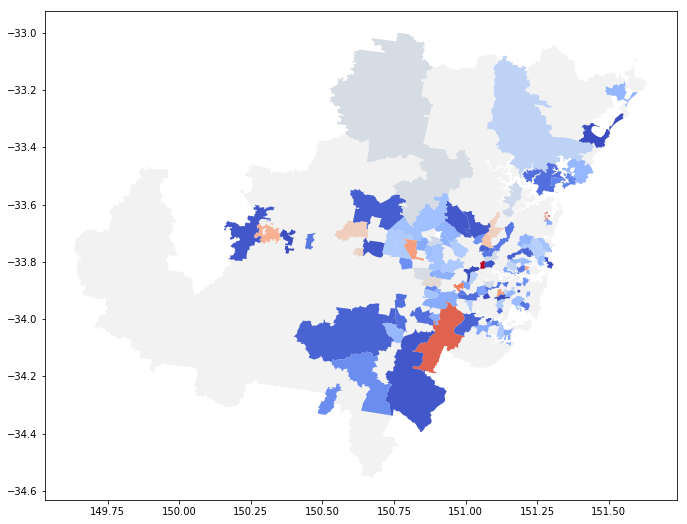

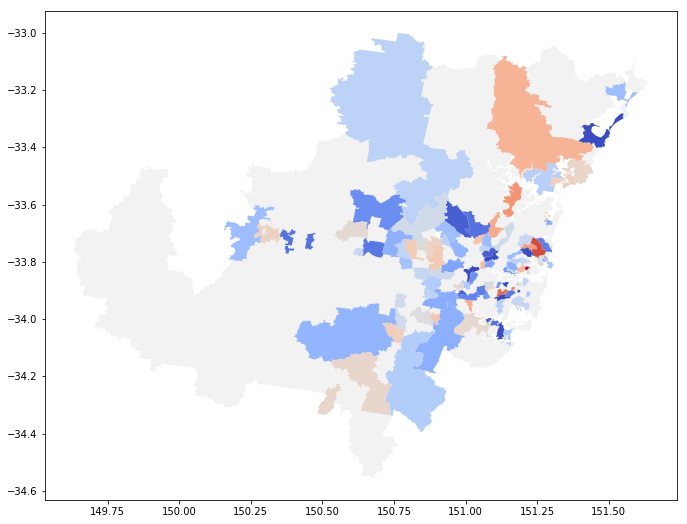

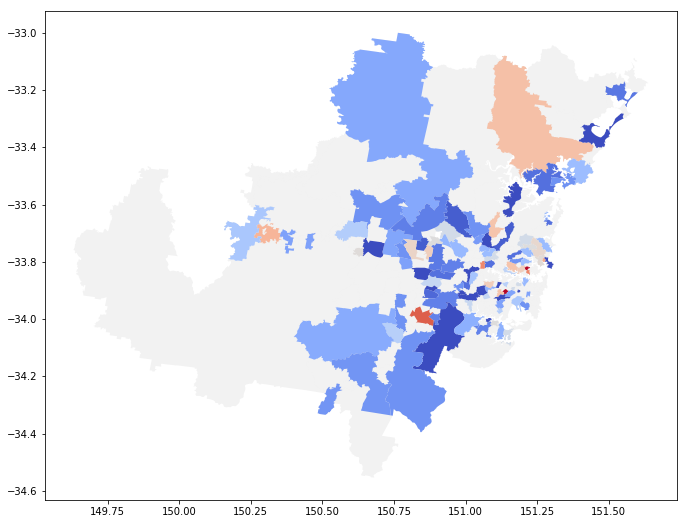

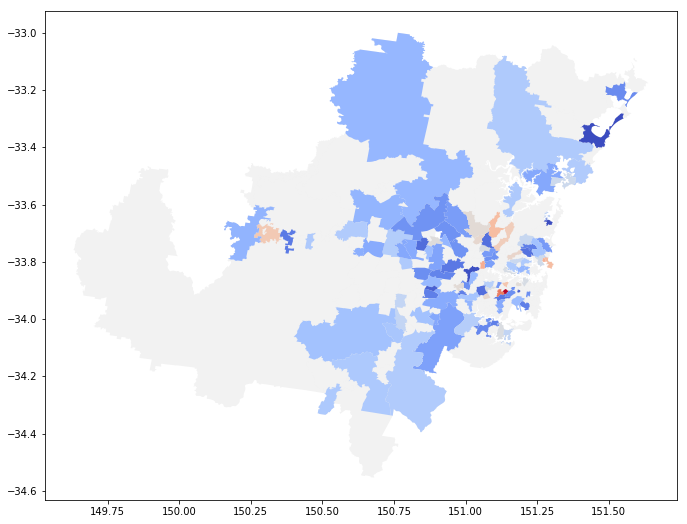

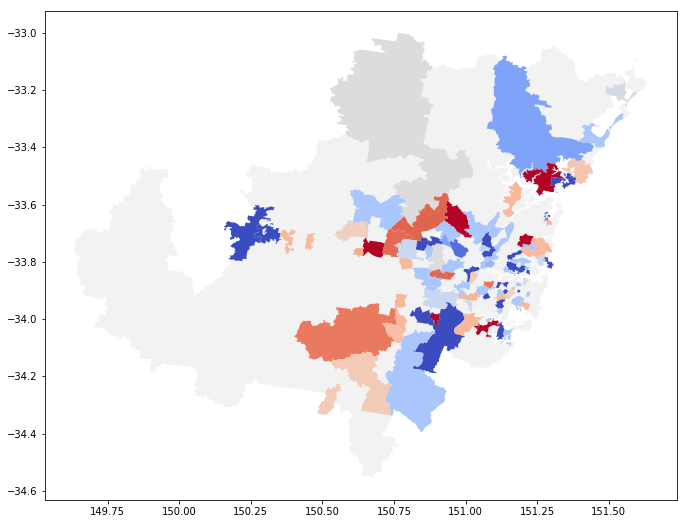

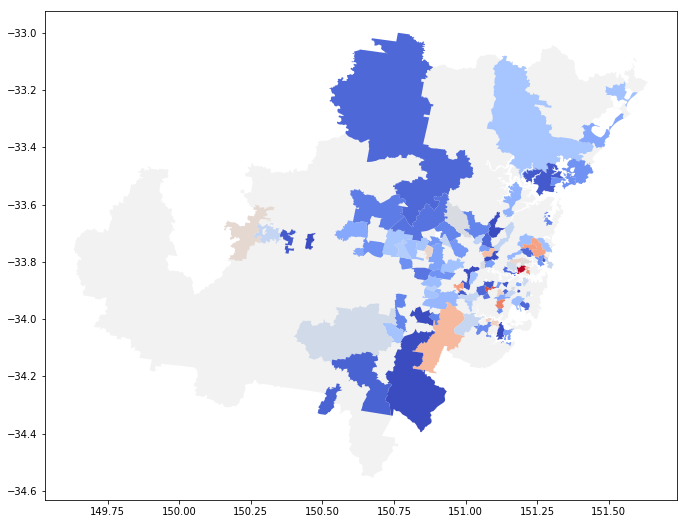

In [313]:
for col in score_vars:
    ax = d_syd.plot(color="grey", alpha = 0.1)
    vals = d_syd[pd.notnull(d_syd[col])]
    vals.plot(ax = ax, column=col, cmap = 'coolwarm');
    
    

In [390]:
labels = ['Music', 'Heritage', 'Art', 'Literature', 'Television', 'Sports']
for col, label in zip(score_vars, labels):
    print(col)
    print(label)

score_consumption_music
Art Participation
score_consumption_heritage
Art Participation
score_consumption_art
Art Participation
score_consumption_literature
Art Participation
score_consumption_television
Art Participation
score_consumption_sports
Art Participation


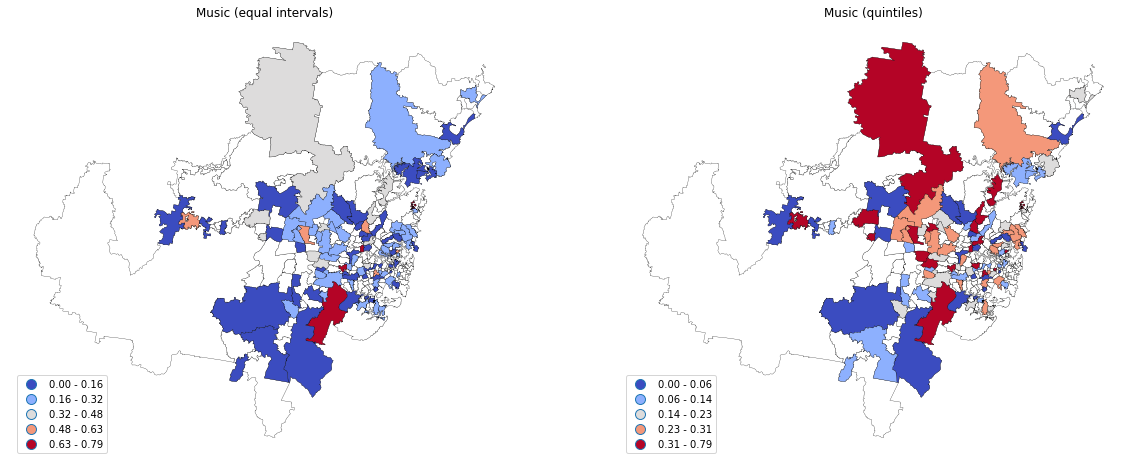

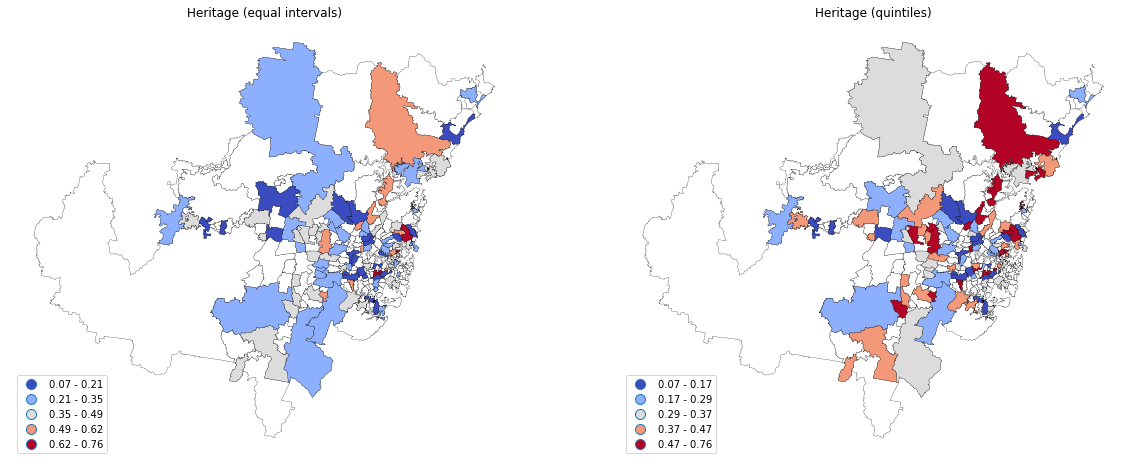

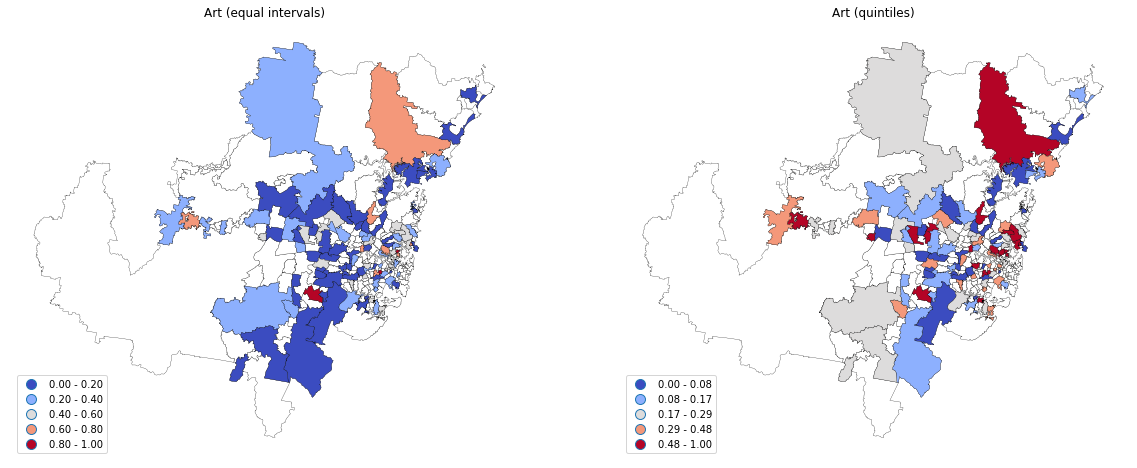

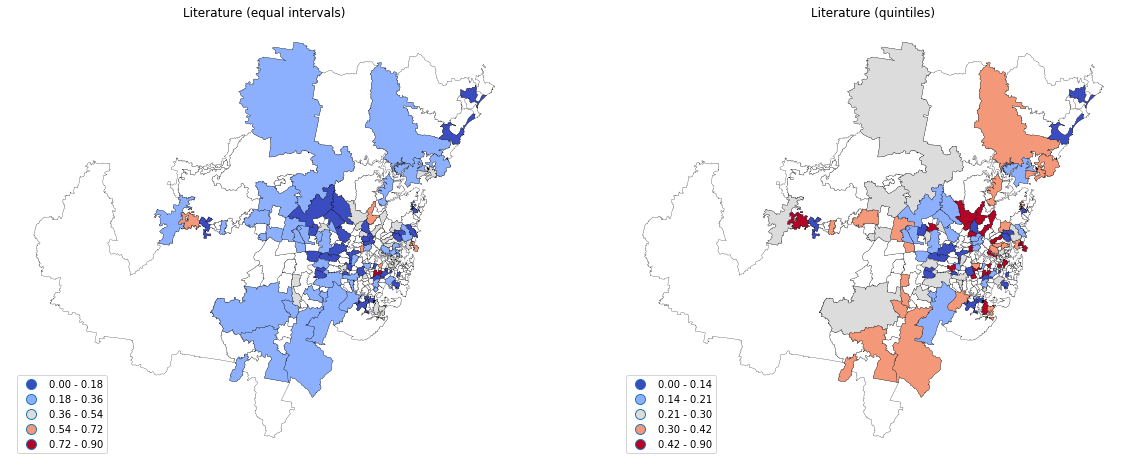

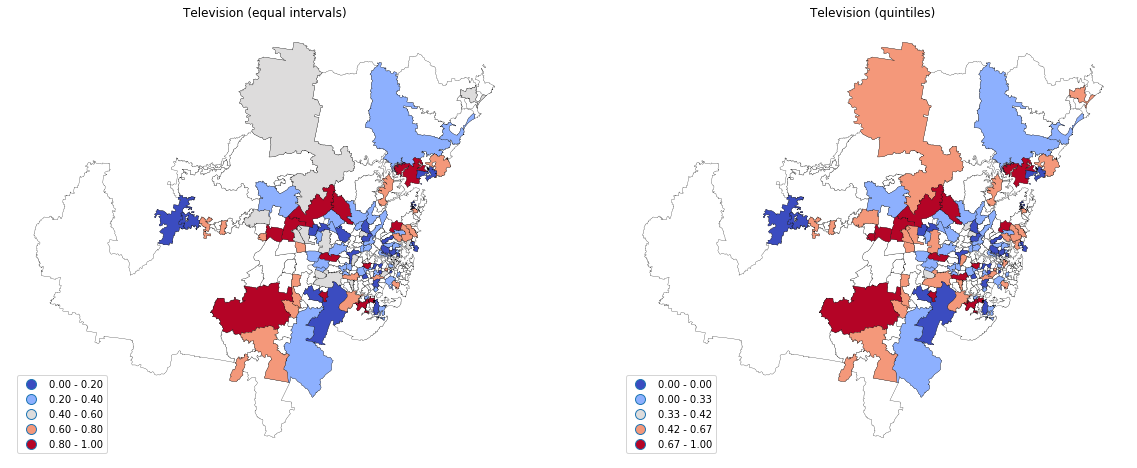

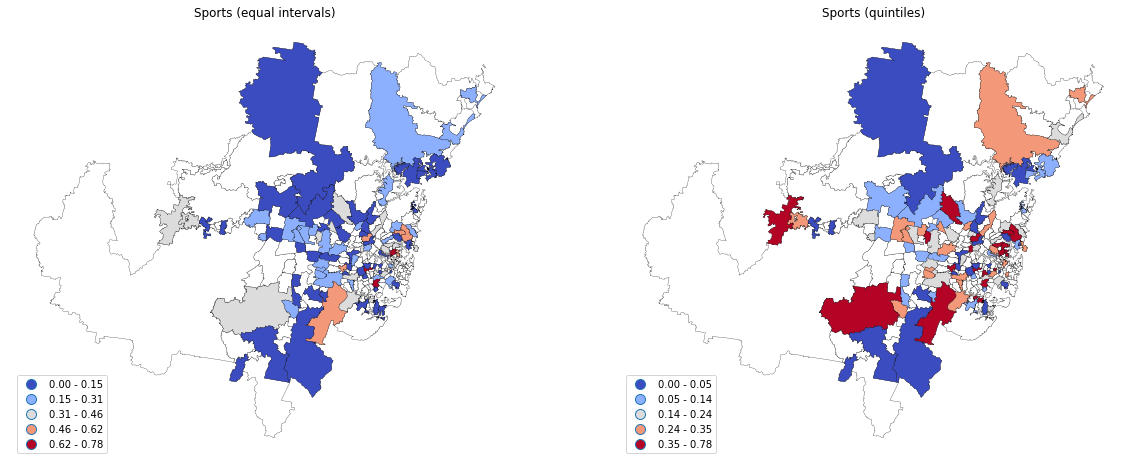

In [393]:
labels = ['Music', 'Heritage', 'Art', 'Literature', 'Television', 'Sports']

for col, label in zip(score_vars, labels):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    ax = axes[0]
    d_syd.plot(ax = ax, color="white", figsize = (6, 6), **{'linewidth': 0.25, 'edgecolor': '0.0'})
    vals = d_syd[pd.notnull(d_syd[col])]
    vals.plot(ax = ax, scheme = "equal_interval", k = 5, column=col, cmap = 'coolwarm', legend=True, **{'linewidth': 0.25, 'edgecolor': '0.0'}) # , **{'linewidth': 0.25, 'edgecolor': '0.5'}, **{'edgecolor': 'g'}
    ax.set_axis_off()
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
    ax.set_title(label + ' (equal intervals)')
    ax.set_yticks([])
    ax.set_xticks([]);

    ax = axes[1]
    d_syd.plot(ax = ax, color="white", figsize = (6, 6), **{'linewidth': 0.25, 'edgecolor': '0.0'})
    vals = d_syd[pd.notnull(d_syd[col])]
    vals.plot(ax = ax, scheme = "Quantiles", k = 5, column=col, cmap = 'coolwarm', legend=True, **{'linewidth': 0.25, 'edgecolor': '0.0'}) # , **{'linewidth': 0.25, 'edgecolor': '0.5'}, **{'edgecolor': 'g'}
    ax.set_axis_off()
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
    ax.set_title(label + ' (quintiles)')
    ax.set_yticks([])
    ax.set_xticks([]);

#### Postal Area Correlations

In [290]:
d_syd_corrs = d_syd[score_vars + ['dist_to_cbd', 'dist_to_cbd_lon', 'dist_to_cbd_lat',
       'score_adv_disadv', 'score_disadv', 
       'score_eco_resource', 'score_edu_occ']]


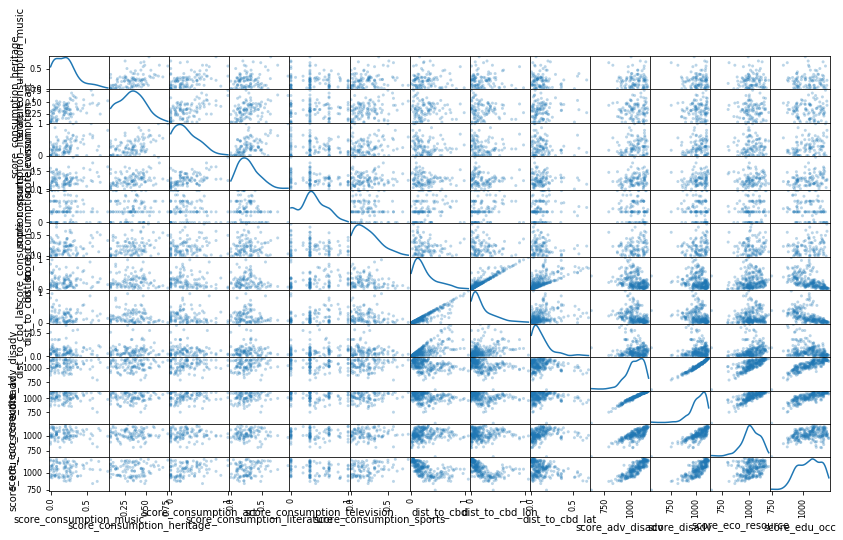

In [291]:
# From https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
sm = pd.plotting.scatter_matrix(d_syd_corrs, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
sm;

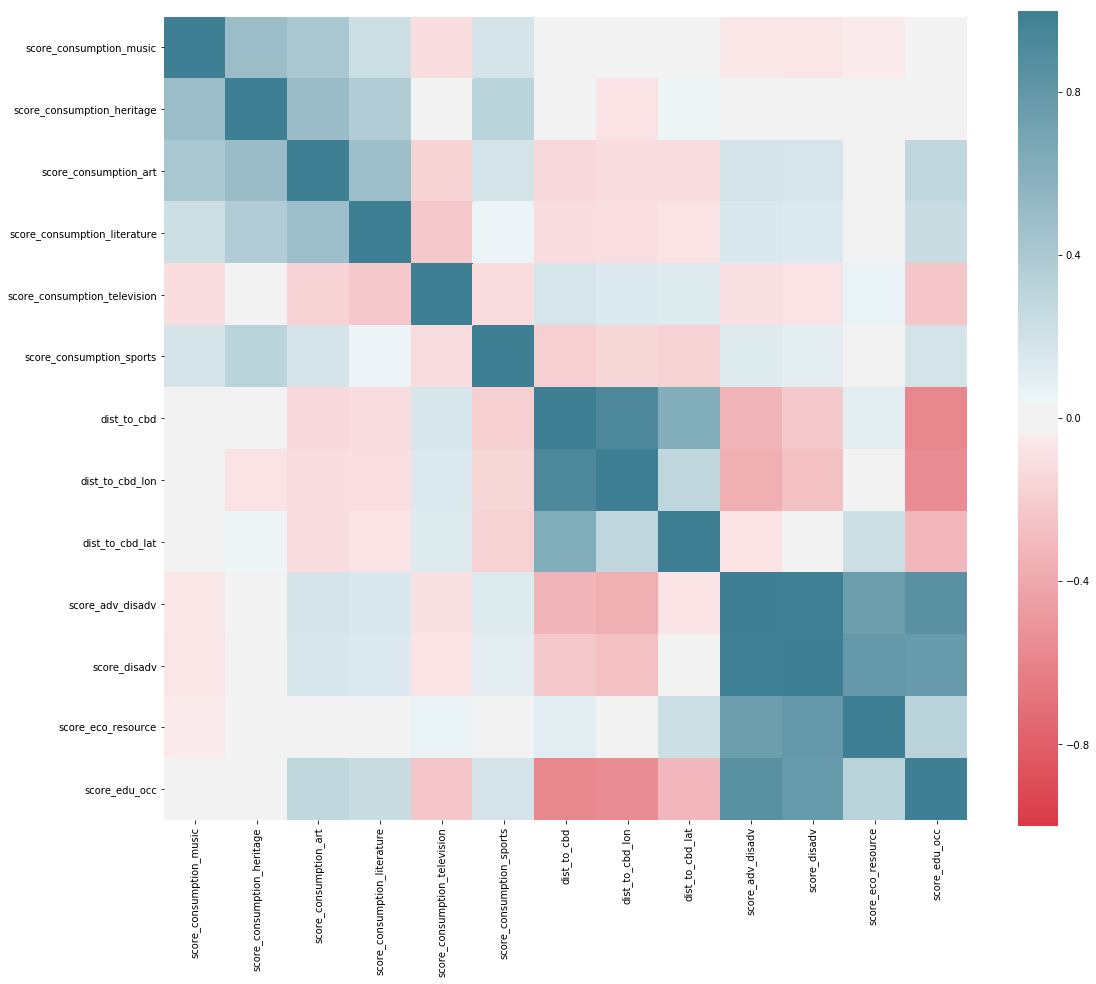

In [292]:
f, ax = plt.subplots(figsize=(18, 15))
corr = d_syd_corrs.corr()
sns.heatmap(corr, vmin = -1.0, vmax = 1.0, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True),
            square=True, ax=ax);

#### Individual Correlations

In [1441]:
d_syd.columns

Index(['POA_CODE16', 'POA_NAME16', 'AREASQKM16', 'geometry', 'centroids',
       'centroids_x', 'centroids_y', 'postcode_x', 'geom_sim', 'dist_to_cbd',
       'dist_to_cbd_lon', 'dist_to_cbd_lat', 'score_music_hours',
       'score_music_frequency', 'score_heritage_internet',
       'score_heritage_visits', 'score_heritage_subscriber', 'score_gallery',
       'score_locations', 'score_internet', 'score_lit_aus_books',
       'score_lit_books', 'score_lit_ebooks', 'score_lit_attendance',
       'score_television_hours', 'score_sports_play', 'score_sports_clubs',
       'score_sports_watched_live', 'score_sports_watched_media',
       'score_music_consumption', 'score_heritage_consumption',
       'score_art_consumption', 'score_literature_consumption',
       'score_television_consumption', 'score_sports_consumption',
       'postcode_y', 'score_adv_disadv', 'decile_adv_disadv', 'score_disadv',
       'decile_disadv', 'score_eco_resource', 'decile_eco_resource',
       'score_edu_occ', 

In [293]:
ds_syd = ds_syd.assign(postcode = ds_syd.Q4)

In [294]:
ds_syd_merged = ds_syd.merge(d_syd[['POA_CODE16', 'density', 'dist_to_cbd', 'dist_to_cbd_lat', 'dist_to_cbd_lon']], 
                             how = 'left', left_on = 'postcode', right_index = True)

In [295]:
ds_syd_merged = ds_syd_merged.assign(
    edu = ds_syd_merged.Q61,
    cult_activities = ds_syd_merged.Q84,
    income = ds_syd_merged.Q89,
    savings = ds_syd_merged.Q92)

In [ ]:
ds_syd_merged.drop

In [296]:
ds_syd_merged = ds_syd_merged[ds_syd_merged['soc8cla'] < 9.]

In [299]:
cols_corr = score_vars + [
            "soc8cla",
            "age",
            "edu",
            "income",
            "savings",
            "density", 
            "dist_to_cbd"]

In [300]:
print("Ave. age:" , ds.data['age'].mean())
print("Ave. age of routine:" , ds.data[ds.data['soc8cla']==8.0]['age'].mean())
print("Ave. age of never worked:" , ds.data[ds.data['soc8cla']==9.0]['age'].mean())

Ave. age: 50.14321819713564
Ave. age of routine: 46.12222222222222
Ave. age of never worked: 24.583333333333332


In [306]:
ds_syd_merged['savings'].value_counts()

9.0    29
6.0    25
1.0    22
4.0    21
7.0    15
2.0    14
8.0    12
5.0    11
3.0     8
Name: savings, dtype: int64

In [301]:
ds.data[['soc8cla', 'age']].corr()

,soc8cla,age
soc8cla,1.00000,-0.20196
age,-0.20196,1.00000


In [302]:
ds.freq_table('soc8cla')

,NS-SEC soc2010 8 social classes,Freq.,Freq. Rel.,Freq. Weighted,Freq. Weighted Rel.
index,,,,,
1.0,Large owners/high man,45,3.7,51.573241,4.3
2.0,High professional,143,11.9,144.405417,12.0
3.0,Lower man/prof,378,31.4,374.868982,31.2
4.0,Intermediate occup,113,9.4,114.149986,9.5
5.0,Small employer/own account,142,11.8,137.638006,11.4
6.0,Low superv/technical,89,7.4,89.298490,7.4
7.0,Semi-routine,161,13.4,160.932157,13.4
8.0,Routine,91,7.6,88.742395,7.4
9.0,Never worked,24,2.0,21.579622,1.8


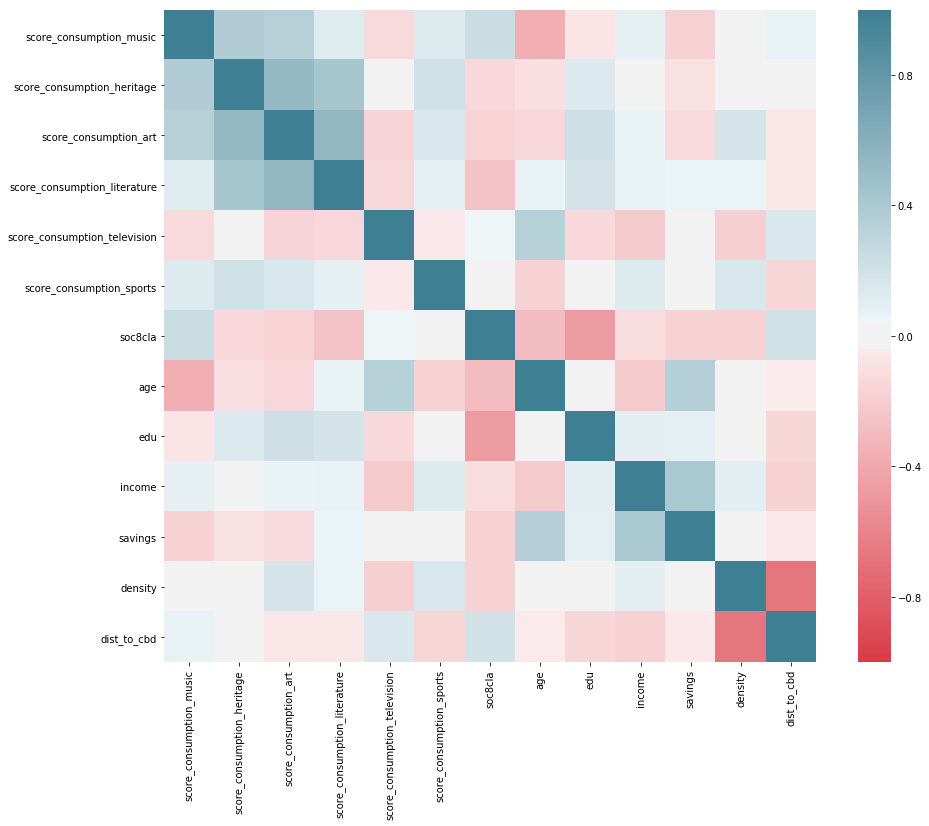

In [303]:
f, ax = plt.subplots(figsize=(15, 12))
ind_corrs = ds_syd_merged[cols_corr].corr()
sns.heatmap(ind_corrs, vmin = -1.0, vmax = 1.0, mask=np.zeros_like(ind_corrs, dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True),
            square=True, ax=ax);

### Principal Component Analysis

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [1473]:
#[print(x) for x in ds_syd_merged.columns]

In [397]:
cols_corr

['score_consumption_music',
 'score_consumption_heritage',
 'score_consumption_art',
 'score_consumption_literature',
 'score_consumption_television',
 'score_consumption_sports',
 'soc8cla',
 'age',
 'edu',
 'income',
 'savings',
 'density',
 'dist_to_cbd']

In [398]:
ds_syd_merged['age'].fillna(np.mean(ds_syd_merged['age']), inplace = True)

In [399]:
ds_syd_merged.loc[:, cols_corr[7]].values


array([64.     , 54.     , 37.     , 78.     , 66.     , 42.     , 52.     , 47.     , 58.     , 78.     ,
       80.     , 46.     , 58.     , 20.     , 72.     , 52.     , 40.     , 61.     , 47.15484, 62.     ,
       ..., 57.     , 34.     , 43.     , 36.     , 22.     , 18.     , 29.     , 25.     , 18.     ,
       25.     , 28.     , 39.     , 20.     , 18.     , 19.     , 27.     , 22.     , 23.     , 27.     ,
       23.     ])

In [400]:
from sklearn.preprocessing import StandardScaler
features = cols_corr
# Separating out the features
x = ds_syd_merged.loc[:, features].values

# Separating out the target
y = ds_syd_merged.loc[:,['sex']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)


In [440]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'], index = ds_syd_merged.index)
finalDf = pd.concat([principalDf, ds_syd_merged.loc[:,['sex']]], axis = 1)

In [441]:
finalDf['sex'].value_counts()

0.0    84
1.0    73
Name: sex, dtype: int64

In [442]:
finalDf['principal component 1']

4      -1.934094
9       0.594597
11      4.312835
18      0.030493
20      0.865025
36     -1.462307
56      1.922907
60     -0.637895
68     -1.473909
73      1.491975
79     -2.774181
81     -1.667201
91      0.306827
97      3.825417
98      2.870164
103    -1.541818
112     2.107870
113    -0.168042
128    -1.965381
129    -0.204120
131     2.143941
141     1.685606
147    -0.621000
149    -0.309749
168     0.773158
174     1.904181
182    -1.528821
196     0.097306
199    -1.175982
203     2.305842
          ...   
962     2.232537
976     0.884019
1000    0.703838
1007   -1.764480
1008    2.838675
1043    1.525569
1058   -0.453969
1066    3.430477
1073   -1.469524
1080   -0.684457
1093    1.234847
1094    0.725283
1099   -1.012581
1104    0.012129
1105    0.181535
1111    0.631681
1113    0.693468
1119    0.433488
1120    2.812230
1126   -2.142722
1130   -0.454399
1139   -0.257319
1141    0.305700
1142   -0.723866
1160    2.125941
1166   -0.612967
1173    1.900220
1177    0.6186

In [422]:
features

['score_consumption_music',
 'score_consumption_heritage',
 'score_consumption_art',
 'score_consumption_literature',
 'score_consumption_television',
 'score_consumption_sports',
 'soc8cla',
 'age',
 'edu',
 'income',
 'savings',
 'density',
 'dist_to_cbd']

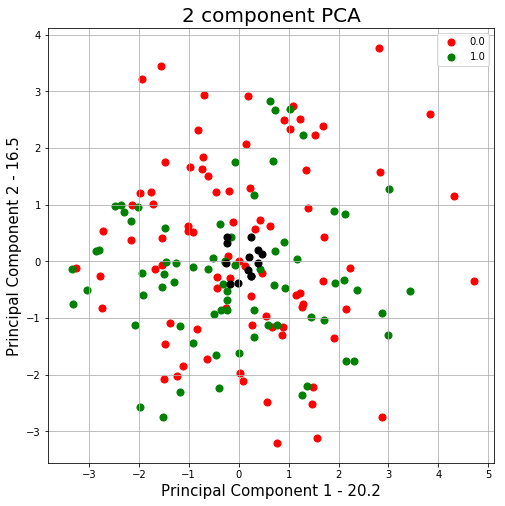

In [432]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 - ' + str((100*pca.explained_variance_ratio_[0]).round(1)), fontsize = 15)
ax.set_ylabel('Principal Component 2 - ' + str((100*pca.explained_variance_ratio_[1]).round(1)), fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0., 1.]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['sex'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.scatter(pca.components_[0], pca.components_[1], c = 'k', s = 50)
ax.legend(targets)
ax.grid()

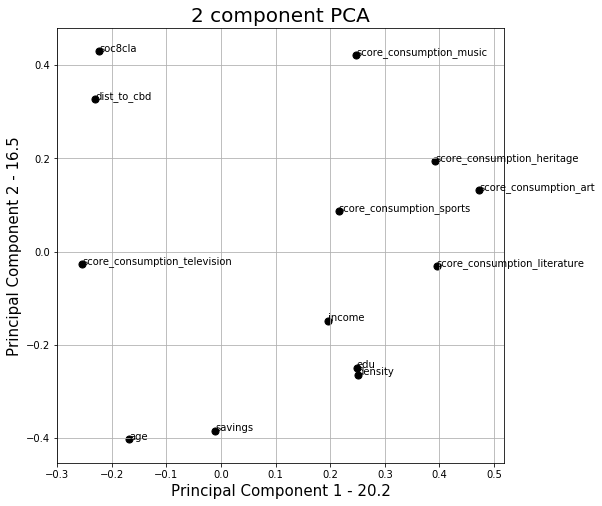

In [436]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 - ' + str((100*pca.explained_variance_ratio_[0]).round(1)), fontsize = 15)
ax.set_ylabel('Principal Component 2 - ' + str((100*pca.explained_variance_ratio_[1]).round(1)), fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0., 1.]
colors = ['r', 'g', 'b']
ax.scatter(pca.components_[0], pca.components_[1], c = 'k', s = 50)
for i, txt in enumerate(features):
    ax.annotate(str(txt), (pca.components_[0, i], pca.components_[1, i]))

ax.grid()

In [426]:
print(pca.explained_variance_ratio_)


[0.20196 0.16502]


In [429]:
print(pca.components_)


[[ 0.24716  0.39204  0.4729   0.39493 -0.25435  0.21533 -0.22317 -0.16858  0.24903  0.19666 -0.01011
   0.25004 -0.23022]
 [ 0.42239  0.19502  0.13314 -0.03065 -0.02671  0.08667  0.42926 -0.40265 -0.25019 -0.14809 -0.38486
  -0.26504  0.32768]]


# Deep Learning Experiments

In [324]:
import torch

In [412]:
acf['dummy'] = 0.


In [413]:
# cat_vars = ['Q39C1']
cat_vars = ['STATE', 'Q38', 'Q39C1', 'Q39C2', 'Q39C3', 'Q39C4', 'Q39C5', 'Q39C6', 'Q39C7', 'Q39C8', 'Q39C9', 
           'Q40C1', 'Q40C2', 'Q40C3', 'Q40C4', 'Q40C5', 'sex', 'emplst']
# , 'soc8cla'

# contin_vars = ['soc4cla']
contin_vars = ['dummy']
#contin_vars = ['Q38', 'soc8cla', 'soc4cla', 'soc3cla']
#contin_vars = ['soc8cla']

In [414]:
contin2_vars = []
# contin2_vars = ["Q5", "Q16", "Q24", "Q25", "Q37", "q49", "q50", "q51", "q56", ]

In [415]:
contin2_vars = [t.upper() for t in contin2_vars]
print(contin2_vars)

[]


In [416]:
cat2_vars = ["Q5", "Q16", "Q24", "Q25", "Q37", "q49", "q50", "q51", "q56", ]
cat2_vars = ["Q7c1", "Q7c2", "Q7c3", "Q7c4",
              "Q7c5", "Q7c6", "Q7c7", "Q7c8", "Q7c9", "Q7c10", "Q7c11", "Q8c1", "Q8c2", "Q8c3", "Q8c4", "Q8c5", "Q8c6", "Q8c7", "Q8c8", "Q8c9", "Q8c10", "Q8c11", "Q9c1", "Q9c2", "Q9c3", "Q9c4", "Q9c5", "Q9c6", "Q9c7", "Q9c8", "Q9c9", "Q13a_1", "Q13a_2", "Q13b_1", "Q13b_2", "Q13c_1", "Q13c_2", "Q13d_1", "Q13d_2", "Q13e_1", "Q13e_2", "Q13f_1", "Q13f_2", "Q13g_1"]
cat2_vars += ["Q13g_2", "Q13h_1", "Q13h_2", "Q13i_1", "Q13i_2", "Q13j_1", "Q13j_2", "Q14a_1", "Q14a_2", "Q14b_1", "Q14b_2", "Q14c_1", "Q14c_2", "Q14d_1", "Q14d_2", "Q14e_1", "Q14e_2", "Q14f_1", "Q14f_2", "Q14g_1", "Q14g_2", "Q14h_1", "Q14h_2", "Q14i_1", "Q14i_2", "Q14j_1", "Q14j_2", "Q15a_1", "Q15a_2", "Q15b_1", "Q15b_2", "Q15c_1", "Q15c_2", "Q15d_1", "Q15d_2", "Q15e_1", "Q15e_2", "Q15f_1", "Q15f_2", "Q15g_1", "Q15g_2", "Q15h_1", "Q15h_2", "Q15i_1", "Q15i_2", "Q15j_1", "Q15j_2",  "Q17", "Q18c1", "Q18c2", "Q18c3", "Q18c4", "Q18c5", "Q18c6", "Q18c7", "Q18c8", "Q18c9", "Q18c10", "Q18c11", "Q19c1", "Q19c2", "Q19c3", "Q19c4", "Q19c5", "Q19c6", "Q19c7", "Q19c8", "Q19c9", "Q19c10", "Q19c11", "Q20c1", "Q20c2", "Q20c3", "Q20c4", "Q20c5", "Q20c6", "Q20c7", "Q20c8", "Q20c9", "Q20c10", "Q20c11", "Q21c1", "Q21c2", "Q21c3", "Q21c4", "Q21c5", "Q21c6", "Q21c7", "Q21c8", "Q21c9", "Q21c10", "Q22a_1", "Q22a_2", "Q22b_1", "Q22b_2", "Q22c_1", "Q22c_2", "Q22d_1", "Q22d_2", "Q22e_1", "Q22e_2", "Q22f_1", "Q22f_2", "Q22g_1", "Q22g_2", "Q22h_1", "Q22h_2", "Q22i_1", "Q22i_2", "Q22j_1", "Q22j_2", "Q23a_1", "Q23a_2", "Q23b_1", "Q23b_2", "Q23c_1", "Q23c_2", "Q23d_1", "Q23d_2", "Q23e_1", "Q23e_2", "Q23f_1", "Q23f_2", "Q23g_1", "Q23g_2", "Q23h_1", "Q23h_2", "Q23i_1", "Q23i_2", "Q23j_1", "Q23j_2"]
cat2_vars += ["Q26a", "Q26b", "Q26c", "Q26d", "Q26e", "Q26f", "Q27c1", "Q27c2", "Q27c3", "Q27c4", "Q27c5", "Q27c6", "Q27c7", "Q27c8", "Q27c9", "Q27c10", "Q27c11", "Q28c1", "Q28c2", "Q28c3", "Q28c4", "Q28c5", "Q28c6", "Q28c7", "Q28c8", "Q28c9", "Q28c10", "Q28c11", "Q29a_1", "Q29a_2", "Q29b_1", "Q29b_2", "Q29c_1", "Q29c_2", "Q29d_1", "Q29d_2", "Q29e_1", "Q29e_2", "Q29f_1", "Q29f_2", "Q29g_1", "Q29g_2", "Q29h_1", "Q29h_2", "Q29i_1", "Q29i_2", "Q29j_1", "Q29j_2", "Q30a_1", "Q30a_2", "Q30b_1", "Q30b_2", "Q30c_1", "Q30c_2", "Q30d_1", "Q30d_2", "Q30e_1", "Q30e_2", "Q30f_1", "Q30f_2", "Q30g_1", "Q30g_2", "Q30h_1", "Q30h_2", "Q30i_1", "Q30i_2", "Q30j_1", "Q30j_2", "Q31c1", "Q31c2", "Q31c3", "Q31c4", "Q31c5", "Q31c6", "Q31c7", "Q31c8", "Q31c9", "Q31c10", "Q31c11", "Q32c1", "Q32c2", "Q32c3", "Q32c4", "Q32c5", "Q32c6", "Q32c7", "Q32c8", "Q33a_1", "Q33a_2", "Q33b_1", "Q33b_2", "Q33c_1", "Q33c_2", "Q33d_1", "Q33d_2", "Q33e_1", "Q33e_2", "Q33f_1", "Q33f_2", "Q33g_1", "Q33g_2", "Q33h_1", "Q33h_2", "Q33i_1", "Q33i_2", "Q33j_1", "Q33j_2", "Q34a_1", "Q34a_2", "Q34b_1", "Q34b_2", "Q34c_1", "Q34c_2", "Q34d_1", "Q34d_2", "Q34e_1", "Q34e_2", "Q34f_1", "Q34f_2", "Q34g_1", "Q34g_2", "Q34h_1", "Q34h_2", "Q34i_1", "Q34i_2", "Q34j_1", "Q34j_2", "Q35c1", "Q35c2", "Q35c3", "Q35c4", "Q35c5", "Q35c6", "Q35c7", "Q35c8", "Q35c9"]
cat2_vars += ["Q36c1", "Q36c2", "Q36c3", "Q36c4", "Q36c5", "Q36c6", "Q36c7", "Q36c8", "Q36c9", "Q41c1", "Q41c2", "Q41c3", "Q41c4", "Q41c5", "Q41c6", "Q41c7", "Q41c8", "Q41c9", "Q41c10", "Q41c11", "Q42c1", "Q42c2", "Q42c3", "Q42c4", "Q42c5", "Q42c6", "Q42c7", "Q42c8", "Q42c9", "Q42c10", "Q42c11", "Q43a_1", "Q43a_2", "Q43b_1", "Q43b_2", "Q43c_1", "Q43c_2", "Q43d_1", "Q43d_2", "Q43e_1", "Q43e_2", "Q43f_1", "Q43f_2", "Q43g_1", "Q43g_2", "Q43h_1", "Q43h_2", "Q43i_1", "Q43i_2", "Q43j_1", "Q43j_2", "Q44a_1", "Q44a_2", "Q44b_1", "Q44b_2", "Q44c_1", "Q44c_2", "Q44d_1", "Q44d_2", "Q44e_1", "Q44e_2", "Q44f_1", "Q44f_2", "Q44g_1", "Q44g_2", "Q44h_1", "Q44h_2", "Q44i_1", "Q44i_2", "Q44j_1", "Q44j_2", "Q45c1", "Q45c2", "Q45c3", "Q45c4", "Q46c1", "Q46c2", "Q46c3", "Q46c4", "Q46c5", "Q46c6", "Q46c7", "Q46c8", "Q46c9", "Q46c10", "Q46c11", "Q46c12", "Q46c13", "Q46c14", "Q47a_1", "Q47a_2", "Q47b_1", "Q47b_2", "Q47c_1", "Q47c_2", "Q47d_1"]
cat2_vars += ["Q47d_2", "Q47e_1", "Q47e_2", "Q47f_1", "Q47f_2", "Q47g_1", "Q47g_2", "Q47h_1", "Q47h_2", "Q47i_1", "Q47i_2", "Q47j_1", "Q47j_2", "Q48", "Q48a_1", "Q48a_2", "Q48b_1", "Q48b_2", "Q48c_1", "Q48c_2", "Q48d_1", "Q48d_2", "Q48e_1", "Q48e_2", "Q48f_1", "Q48f_2", "Q48g_1", "Q48g_2", "Q48h_1", "Q48h_2", "Q48i_1", "Q48i_2", "Q48j_1", "Q48j_2", "Q52c1", "Q52c2", "Q52c3", "Q52c4", "Q52c5", "Q52c6", "Q52c7", "Q52c8", "Q52c9", "Q52c10", "Q53a", "Q53b", "Q53c", "Q53d", "Q53e", "Q53f", "Q53g", "Q54a", "Q54b", "Q54c", "Q54d", "Q54e", "Q54f", "Q54g", "Q54h", "Q57c1", "Q57c2", "Q57c3", "Q57c4", "Q57c5", "Q57c6", "Q57c7"]

cat3_vars = ["Q58", "Q59", "Q60", "Q61", "Q62", "Q63", "Q64", "Q64o", "Q65", "Q65o", "Q66", "Q67_pipe", "Q67", "Q67o", "Q68", "Q68o", "Q67_abs", "Q69", "Q70", "Q71", "Q72c1", "Q72c2", "Q72c3", "Q72a", "Q72b", "Q73", "Q74_pipe", "Q74", "Q74o", "Q74_abs", "Q75", "Q76c1", "Q76c2", "Q76c3", "Q77", "Q78", "Q79c1", "Q79c2", "Q79c3", "Q79c4", "Q80", "Q80o", "Q83", "Q83o", "Q84", "Q84ac1", "Q84ac2", "Q84ac3", "Q84ac4", "Q84ac5", "Q84ac6", "Q84ac7", "Q85", "Q85o", "Q86", "Q86o", "Q87c1", "Q87c2", "Q87c3", "Q87c4", "Q87c5", "Q87c6", "Q87c7", "Q87c8", "Q87c9", "Q87c10", "Q87c10o", "Q87c11", "Q88a", "Q88b", "Q89", "Q90_select", "Q90", "Q90a", "Q91", "Q92", "Q95", "int99", "int990", "issues", "issueso", "agec7", "nphouh", "educa", "sisoccl", "housinc", "tvwatch", "nitv", "tvauspr", "houlmus", "nebookh", "nbookho", "tspind", "tstind", "tskind", "tspaus", "tstaus", "tskaus", "tspusa", "tstusa", "tskusa", "tspuk", "tstuk", "tskuk", "tspeu", "tsteu", "tskeu", "tspasi", "tstasi", "tskasi", "emplst", "soc8cla", "soc5cla", "soc3cla", "ausenor", "clapref", "sex", "age", "nphouh1", "tvtech", "fatvch", "educap", "edespf", "univst", "coubirt", "educam", "educaf", "valubus", "homwor", "soc4cla", "fatvch1", "Q11o1"]

cat2_vars = [t.upper() for t in cat2_vars]
cat3_vars = [t.upper() for t in cat3_vars]

In [417]:
cat_vars += cat2_vars
contin_vars += contin2_vars

In [418]:
#dep = 'age'
#dep = 'Q61'
dep = 'sex'
cat_vars.remove(dep)

In [419]:
sacf = acf[['RecordNo', 
            dep] + cat_vars + contin_vars]
sacf = sacf.sample(frac=1)

In [420]:
# sacf['age'] = sacf.loc[:,'age'].interpolate()

In [421]:
sacf.dropna(axis=0, how='any', subset=[dep], inplace=True)

In [422]:
#sacf['age'] = sacf['age'].fillna(sacf['age'].mean())

In [423]:
len(sacf['RecordNo'])

1202

In [424]:
#for i in sacf.columns: print(i)

In [425]:
n = len(sacf); n

1202

In [426]:

for v in cat_vars: sacf[v] = sacf[v].astype('category').cat.as_ordered()
for v in contin_vars: sacf[v] = sacf[v].astype('float32')
sacf[dep].astype('float32')
# sacf[dep] = sacf[dep].astype('category').cat.as_ordered()
sacf = sacf[cat_vars+contin_vars+[dep, "RecordNo"]]

In [427]:
sacf['sex'] = sacf['sex'] + .0001

In [428]:
idxs = get_cv_idxs(n, val_pct=1202/n)

In [429]:
sacf = sacf.set_index("RecordNo")

In [430]:
sacf_samp = sacf.iloc[idxs]

In [431]:
samp_size = len(sacf_samp); samp_size

1202

In [432]:
# df, y, nas, mapper = proc_df(sacf_samp, 'soc8cla', do_scale=True)
df, y, nas, mapper = proc_df(sacf, dep, do_scale=True)
yl = np.log(y)

In [433]:

train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [434]:
len(val_idx)

301

In [435]:
md = ColumnarModelData.from_data_frame('data/path', val_idx, df, yl, cat_flds=cat_vars, bs=8)

In [438]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

def mse(y_pred, targ):
    targ = inv_y(targ)
    y_pred = inv_y(y_pred)
    return math.sqrt(((y_pred-targ)**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [439]:
cat_sz = [(c, len(sacf_samp[c].cat.categories)+1) for c in cat_vars]


In [440]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [441]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)


/home/ubuntu/repos/fastai/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/ubuntu/repos/fastai/fastai/column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


epoch      trn_loss   val_loss   
    0      40.288302  42.556103 



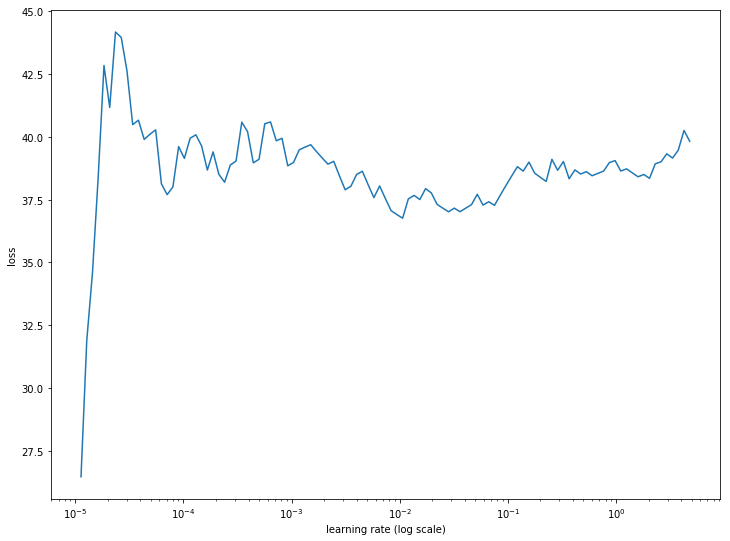

In [442]:
m.lr_find()
m.sched.plot(1)

In [443]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 10e-5 #* 5

/home/ubuntu/repos/fastai/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/ubuntu/repos/fastai/fastai/column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


In [444]:
m.fit(lr,3, metrics=[exp_rmspe,mse]) # , cycle_len=2, cycle_mult=3


epoch      trn_loss   val_loss   exp_rmspe  mse        
    0      38.389917  42.556103  7023.789649 0.702379  
    1      39.524405  42.556103  7023.789649 0.702379  
    2      38.951153  42.556103  7023.789649 0.702379  



[42.55610253723753, 7023.7896490284475, 0.702378870641079]

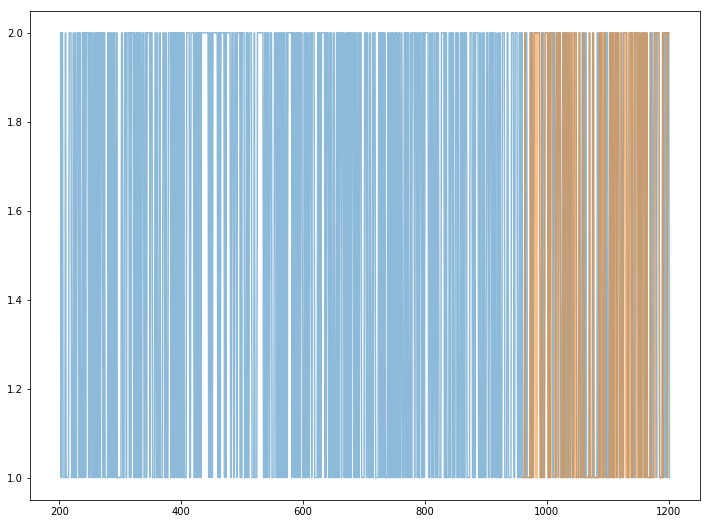

In [388]:
def create_output_df(m, idx):
    outp = pd.DataFrame({"ID":idx,
                         "actual":np.append([np.exp(m.data.trn_y)],[np.exp(m.data.val_y)]), 
                         "predicted":np.append([np.nan for i in m.data.trn_y],[np.round(np.exp(m.predict()))])})
#     outp = pd.DataFrame({"ID":idx,
#                          "actual":np.append([np.exp(m.data.trn_y)],[np.exp(m.data.val_y)]), 
#                          "predicted":np.append([np.nan for i in m.data.trn_y],[np.exp(m.predict())])})
    return(outp)

outp = create_output_df(m,sacf.index)
plt.plot(outp["actual"][-1000:], alpha = 0.5)
# plt.plot(outp["rand"][-1000:], alpha = 0.5)
plt.plot(outp["predicted"][-1000:], alpha = 0.5)
plt.show()


In [389]:
s = sacf[dep].std()
m = sacf[dep].mean()
l = len(sacf[dep])
dist = s * np.random.rand(l) + m

In [409]:
outp['predicted'] = np.round(outp['predicted'])
outp['dp'] = (outp['predicted'] - outp['actual']).abs()
outp['dr'] = np.round((dist - outp['actual']).abs())

print(outp['dp'].mean())
print(outp['dr'].mean())


0.17842323651452283
0.47254575707154745


In [410]:
print("Incorrect guesses:", outp['dp'].sum())
print("Incorrect randoms:", outp['dr'].sum())
print("Percentage accuracy:", 100 * (sum(val_idx) - outp['dp'].sum()) / len(val_idx))

Incorrect guesses: 43.0
Incorrect randoms: 568.0
Percentage accuracy: 105085.71428571429


In [385]:
outp.tail(121)

,ID,actual,predicted,dp,dr
1081,b'0000013543',1.0,1.0,0.0,1.0
1082,b'0000014358',1.0,1.0,0.0,1.0
1083,b'0000019540',2.0,1.0,1.0,0.0
1084,b'0000051049',1.0,1.0,0.0,1.0
1085,b'0000012487',1.0,1.0,0.0,1.0
1086,b'0000008581',2.0,2.0,0.0,0.0
1087,b'0000003575',1.0,1.0,0.0,1.0
1088,b'0000014655',2.0,2.0,0.0,0.0
1089,b'0000057454',2.0,1.0,1.0,0.0
1090,b'0000016866',2.0,2.0,0.0,0.0


In [ ]:
accuracy_np(m.predict(), yl)

In [ ]:
importfrom sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier matplotlib.pyplot as plt
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)
m = RandomForestClassifier(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);


In [ ]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(np.log(preds), np.log(y_val))


In [ ]:
preds

In [ ]:
y_val

In [ ]:
np.sum(np.abs(preds - y_val))

## Logistic Regression

In [ ]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
logreg = LogisticRegression()